In [1]:
%load_ext autoreload
%autoreload 2

from __future__ import print_function, division
import os

os.environ["CUDA_VISIBLE_DEVICES"] = '7'

In [2]:
import ultralytics
from IPython.display import display, Image
from roboflow import Roboflow
import cv2
import sys
import numpy as np
import matplotlib.pyplot as plt

import torch

# Check Ultralytics version and setup completion
ultralytics.checks()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from ultralytics import YOLO

Ultralytics YOLOv8.0.137 🚀 Python-3.9.16 torch-2.1.0.dev20230314 CUDA:0 (NVIDIA A100-SXM4-80GB, 81100MiB)
Setup complete ✅ (128 CPUs, 1007.5 GB RAM, 35.5/48.9 GB disk)


In [71]:
im_path = '/home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/50554919_2069783324.jpg'

# Load the YOLOv8 model
model = YOLO('yolov8n.pt')

# Perform object detection on the image
results = model.predict(source=im_path, conf=0.25)


image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/50554919_2069783324.jpg: 480x640 (no detections), 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


In [73]:
len(results[0])

0

In [42]:
image = cv2.imread(im_path, cv2.IMREAD_COLOR)

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
sam_checkpoint = "/home/zt16/code/priv-nerf/nerfw_pl_priv/sam_ckpt/sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)
predictor.set_image(image)

In [43]:
bbox = []
for boxes in results[0].boxes:
#     import pdb; pdb.set_trace()
    if boxes.cls[0] == 0.:
        bbox.append(boxes.xyxy.tolist()[0])
        
      

In [44]:
predicted_boxes = results[0].boxes.xyxy
transformed_boxes = predictor.transform.apply_boxes_torch(predicted_boxes, image.shape[:2])

In [45]:
predicted_boxes_np=predicted_boxes.cpu().numpy()

In [46]:
# bbox_arr = np.array(bbox)
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)


In [49]:
masks = np.array(masks.cpu())
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

(15, 1, 767, 1023)

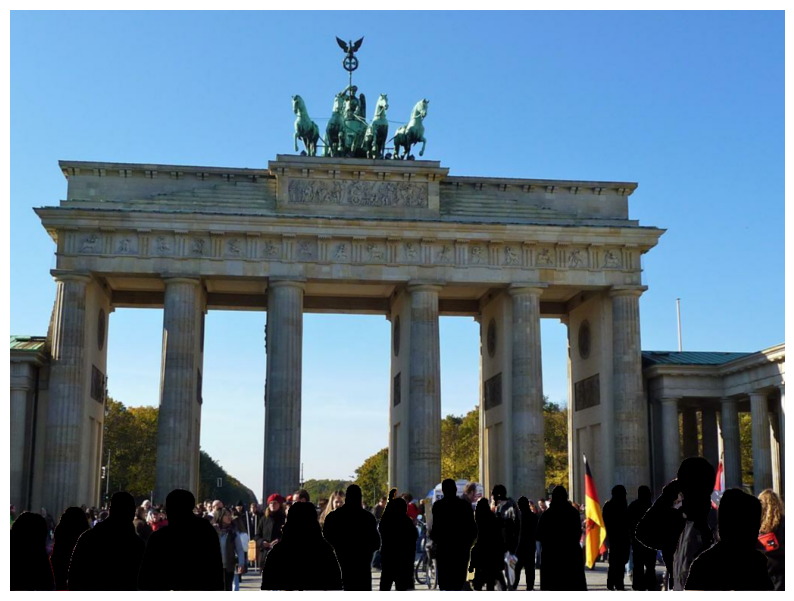

In [60]:

final_mask = None
for i in range(len(masks) - 1):
  if final_mask is None:
    final_mask = np.bitwise_or(masks[i][0], masks[i+1][0])
  else:
    final_mask = np.bitwise_or(final_mask, masks[i+1][0])

final_mask = np.bitwise_not(final_mask)
mask_rgb = np.stack((final_mask,final_mask, final_mask), axis=-1)
result = np.multiply(image_rgb, mask_rgb)

plt.figure(figsize=(10, 10))
# plt.imshow(image_rgb)
plt.axis('off')
plt.imshow(result)

plt.show()

In [63]:
result.shape

(767, 1023, 3)

In [75]:
input_folder = '/home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images'
output_folder = '/home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/masked_images'
    # Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
# Get a list of all files in the input folder
files = os.listdir(input_folder)
import pdb; pdb.set_trace
for file in files:
    print(file)
    im_path = os.path.join(input_folder, file)
    output_path = os.path.join(output_folder, file)
    
    image = cv2.imread(im_path, cv2.IMREAD_COLOR)
#     image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Perform object detection on the image
    results = model.predict(source=im_path, conf=0.25)
    if len(results[0]) == 0:        
        cv2.imwrite(output_path, image)
        continue
        
        
    
    
    predicted_boxes = results[0].boxes.xyxy
    transformed_boxes = predictor.transform.apply_boxes_torch(predicted_boxes, image.shape[:2])

    predictor.set_image(image)

    masks, _, _ = predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes,
        multimask_output=False,
        )
    masks = np.array(masks.cpu())
    
    final_mask = None
    
    for i in range(len(masks) - 1):
      if final_mask is None:
        final_mask = np.bitwise_or(masks[i][0], masks[i+1][0])
      else:
        final_mask = np.bitwise_or(final_mask, masks[i+1][0])
    if final_mask is None:
        result = image
    else:
        final_mask = np.bitwise_not(final_mask)
        mask_rgb = np.stack((final_mask,final_mask, final_mask), axis=-1)
        result = np.multiply(image, mask_rgb)

    
    output_path = os.path.join(output_folder, file)
    cv2.imwrite(output_path, result)

        
        
        
        
        
        
    


image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/60633305_3067485286.jpg: 384x640 12 persons, 1 bicycle, 2 cars, 6.8ms
Speed: 1.5ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


60633305_3067485286.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/71180317_4509734040.jpg: 448x640 1 person, 6.2ms
Speed: 1.6ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


71180317_4509734040.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/27679520_326509985.jpg: 480x640 12 persons, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


27679520_326509985.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/70486856_7507920858.jpg: 640x640 15 persons, 5.6ms
Speed: 1.6ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


70486856_7507920858.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/34695534_2595429960.jpg: 640x480 9 persons, 1 bird, 2 umbrellas, 5.8ms
Speed: 1.4ms preprocess, 5.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


34695534_2595429960.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/02566955_9377454362.jpg: 416x640 12 persons, 5.8ms
Speed: 1.3ms preprocess, 5.8ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


02566955_9377454362.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/11368086_2414129400.jpg: 640x480 14 persons, 3 birds, 6.6ms
Speed: 2.2ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


11368086_2414129400.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/50458546_2493694809.jpg: 480x640 10 persons, 2 backpacks, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


50458546_2493694809.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/84930732_250229702.jpg: 448x640 17 persons, 1 truck, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


84930732_250229702.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/27172053_6893992800.jpg: 448x640 13 persons, 1 backpack, 1 teddy bear, 5.4ms
Speed: 1.3ms preprocess, 5.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


27172053_6893992800.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/99790559_8115599774.jpg: 640x640 1 person, 1 clock, 5.7ms
Speed: 1.6ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


99790559_8115599774.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/87352720_3821935063.jpg: 480x640 16 persons, 1 backpack, 6.6ms
Speed: 2.5ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


87352720_3821935063.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/33328823_4042342949.jpg: 480x640 16 persons, 1 backpack, 3 suitcases, 5.3ms
Speed: 1.4ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


33328823_4042342949.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/19356686_6880121553.jpg: 448x640 2 persons, 1 clock, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


19356686_6880121553.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/54870639_2216920778.jpg: 640x480 3 birds, 5.8ms
Speed: 1.6ms preprocess, 5.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


54870639_2216920778.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/96503183_3428066956.jpg: 448x640 14 persons, 1 motorcycle, 1 handbag, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


96503183_3428066956.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/89499924_393799966.jpg: 480x640 2 birds, 6.5ms
Speed: 2.2ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


89499924_393799966.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/76602992_5007474555.jpg: 480x640 22 persons, 3 umbrellas, 5.3ms
Speed: 1.6ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


76602992_5007474555.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/83495380_5618778940.jpg: 480x640 18 persons, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


83495380_5618778940.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/50554919_2069783324.jpg: 480x640 (no detections), 5.2ms
Speed: 1.2ms preprocess, 5.2ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/84903595_133942193.jpg: 480x640 15 persons, 1 bicycle, 2 cars, 5.0ms
Speed: 1.4ms preprocess, 5.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


50554919_2069783324.jpg
84903595_133942193.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/20580890_6015148266.jpg: 448x640 4 horses, 1 clock, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


20580890_6015148266.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/96926097_5975420106.jpg: 480x640 12 persons, 2 cars, 4 umbrellas, 1 handbag, 6.3ms
Speed: 2.0ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


96926097_5975420106.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/57095103_8630359921.jpg: 640x480 7 persons, 2 chairs, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


57095103_8630359921.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/68785884_7333978918.jpg: 480x640 14 persons, 1 car, 2 backpacks, 6 umbrellas, 1 handbag, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


68785884_7333978918.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/37836697_765012344.jpg: 480x640 21 persons, 1 handbag, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


37836697_765012344.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/11837123_2947074063.jpg: 448x640 15 persons, 1 motorcycle, 1 umbrella, 5.8ms
Speed: 1.5ms preprocess, 5.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


11837123_2947074063.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/09390945_765838744.jpg: 416x640 13 persons, 1 bicycle, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


09390945_765838744.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/74852535_189159122.jpg: 448x640 12 persons, 1 bicycle, 1 car, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


74852535_189159122.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/66631662_135912332.jpg: 480x640 13 persons, 1 backpack, 1 handbag, 6.4ms
Speed: 2.1ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


66631662_135912332.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/22060572_3061456830.jpg: 448x640 16 persons, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


22060572_3061456830.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/46864195_2723640079.jpg: 448x640 14 persons, 1 truck, 5.1ms
Speed: 1.3ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


46864195_2723640079.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/40983428_1134385064.jpg: 640x480 11 persons, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


40983428_1134385064.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/18674302_730638793.jpg: 384x640 18 persons, 2 bicycles, 1 car, 5.7ms
Speed: 1.2ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


18674302_730638793.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/26970544_3644140558.jpg: 640x480 6 persons, 1 car, 1 bird, 1 clock, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


26970544_3644140558.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/32093781_9123747064.jpg: 480x640 13 persons, 1 car, 1 truck, 1 bird, 2 handbags, 5.5ms
Speed: 1.2ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


32093781_9123747064.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/77174563_5012249156.jpg: 480x640 14 persons, 2 birds, 5.3ms
Speed: 1.6ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


77174563_5012249156.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/05500049_3659727262.jpg: 480x640 18 persons, 1 car, 3 handbags, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


05500049_3659727262.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/94045317_3752214176.jpg: 416x640 14 persons, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


94045317_3752214176.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/90747415_2886558519.jpg: 480x640 9 persons, 3 handbags, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


90747415_2886558519.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/22522580_3798990626.jpg: 640x448 2 birds, 76.0ms
Speed: 1.7ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


22522580_3798990626.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/78611241_133942103.jpg: 480x640 8 persons, 1 umbrella, 1 handbag, 6.5ms
Speed: 2.2ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


78611241_133942103.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/04816924_4491326956.jpg: 480x640 13 persons, 1 umbrella, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


04816924_4491326956.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/04683648_2472127584.jpg: 480x640 15 persons, 5.3ms
Speed: 1.5ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


04683648_2472127584.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/17898648_76597490.jpg: 480x640 14 persons, 1 truck, 1 bird, 1 handbag, 5.3ms
Speed: 1.5ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


17898648_76597490.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/20050853_9360512514.jpg: 544x640 3 horses, 72.4ms
Speed: 1.6ms preprocess, 72.4ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


20050853_9360512514.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/08455944_11844596793.jpg: 448x640 19 persons, 6 bicycles, 1 tie, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


08455944_11844596793.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/68713697_3822730864.jpg: 480x640 17 persons, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


68713697_3822730864.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/98143716_5974984669.jpg: 480x640 14 persons, 1 handbag, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


98143716_5974984669.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/95596779_6880111501.jpg: 448x640 13 persons, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


95596779_6880111501.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/92884278_346751510.jpg: 480x640 1 bird, 1 horse, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


92884278_346751510.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/08507139_7168341023.jpg: 480x640 3 birds, 5.1ms
Speed: 1.4ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


08507139_7168341023.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/55382494_6220864459.jpg: 448x640 13 persons, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


55382494_6220864459.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/16889752_2793574457.jpg: 448x640 8 persons, 5.8ms
Speed: 1.9ms preprocess, 5.8ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


16889752_2793574457.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/67975654_219272213.jpg: 480x640 21 persons, 3 cars, 5.8ms
Speed: 1.5ms preprocess, 5.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


67975654_219272213.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/93110830_1932760362.jpg: 480x640 (no detections), 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/69056636_3741876483.jpg: 480x640 10 persons, 2 bicycles, 8 cars, 1 motorcycle, 1 backpack, 2 handbags, 5.1ms
Speed: 1.4ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


93110830_1932760362.jpg
69056636_3741876483.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/54714905_6154442539.jpg: 480x640 20 persons, 5.3ms
Speed: 1.5ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


54714905_6154442539.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/63260757_9123850932.jpg: 480x640 4 birds, 5.2ms
Speed: 1.2ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


63260757_9123850932.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/64721245_2188160810.jpg: 640x480 20 persons, 1 car, 2 backpacks, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


64721245_2188160810.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/82920480_8643140227.jpg: 448x640 (no detections), 5.7ms
Speed: 1.3ms preprocess, 5.7ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/16363245_2856211602.jpg: 640x480 (no detections), 5.4ms
Speed: 1.4ms preprocess, 5.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/59992063_2205272991.jpg: 480x640 17 persons, 5.3ms
Speed: 1.3ms preprocess, 5.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


82920480_8643140227.jpg
16363245_2856211602.jpg
59992063_2205272991.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/56078266_4086845418.jpg: 480x640 3 trucks, 5.1ms
Speed: 1.4ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


56078266_4086845418.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/87315572_37762236.jpg: 480x640 (no detections), 5.1ms
Speed: 1.4ms preprocess, 5.1ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/33309506_3455593447.jpg: 640x480 7 persons, 3 birds, 1 handbag, 5.4ms
Speed: 1.3ms preprocess, 5.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


87315572_37762236.jpg
33309506_3455593447.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/56470167_2217965889.jpg: 544x640 16 persons, 1 car, 2 birds, 5.6ms
Speed: 1.6ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


56470167_2217965889.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/62491248_4610291618.jpg: 480x640 26 persons, 1 bicycle, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


62491248_4610291618.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/67538178_857813536.jpg: 480x640 1 bird, 5.4ms
Speed: 1.7ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


67538178_857813536.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/27541834_311888773.jpg: 640x480 7 persons, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


27541834_311888773.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/04371528_389640014.jpg: 480x640 26 persons, 2 umbrellas, 5.5ms
Speed: 1.5ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


04371528_389640014.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/01054272_4619185109.jpg: 640x416 8 persons, 1 chair, 70.3ms
Speed: 1.2ms preprocess, 70.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


01054272_4619185109.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/66283604_3172930925.jpg: 416x640 9 persons, 5.6ms
Speed: 1.2ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


66283604_3172930925.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/60073534_5307652197.jpg: 416x640 11 persons, 1 car, 1 truck, 5.3ms
Speed: 1.5ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


60073534_5307652197.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/63338063_2848358386.jpg: 448x640 22 persons, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


63338063_2848358386.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/82903083_4663101968.jpg: 480x640 16 persons, 1 bird, 5.6ms
Speed: 1.7ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


82903083_4663101968.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/64706100_5610611317.jpg: 640x448 15 persons, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


64706100_5610611317.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/87880165_6062199757.jpg: 640x480 8 persons, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


87880165_6062199757.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/79065474_8103263530.jpg: 448x640 15 persons, 1 bicycle, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


79065474_8103263530.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/24429125_2973680434.jpg: 480x640 4 horses, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


24429125_2973680434.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/56499896_148285602.jpg: 480x640 15 persons, 5.4ms
Speed: 1.4ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


56499896_148285602.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/41559656_9236243274.jpg: 480x640 1 person, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


41559656_9236243274.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/48093978_8688123505.jpg: 448x640 1 teddy bear, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


48093978_8688123505.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/88927991_2887390816.jpg: 480x640 11 persons, 5.5ms
Speed: 1.5ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


88927991_2887390816.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/94597491_3848863160.jpg: 416x640 18 persons, 1 umbrella, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


94597491_3848863160.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/26304552_6880111823.jpg: 448x640 13 persons, 1 bicycle, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


26304552_6880111823.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/99451773_2694323455.jpg: 448x640 14 persons, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


99451773_2694323455.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/45904560_1481586730.jpg: 416x640 3 birds, 5.8ms
Speed: 1.2ms preprocess, 5.8ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


45904560_1481586730.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/31103275_3427070289.jpg: 448x640 (no detections), 6.0ms
Speed: 1.6ms preprocess, 6.0ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/98942684_2748037643.jpg: 480x640 10 persons, 2 birds, 5.8ms
Speed: 1.6ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


31103275_3427070289.jpg
98942684_2748037643.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/99002117_2965987139.jpg: 480x640 20 persons, 2 cars, 5.2ms
Speed: 1.3ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


99002117_2965987139.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/44028209_3953904906.jpg: 640x480 12 persons, 1 bird, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


44028209_3953904906.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/39180613_1358271934.jpg: 480x640 11 persons, 1 bicycle, 1 car, 5.6ms
Speed: 1.6ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


39180613_1358271934.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/11222841_4278491959.jpg: 448x640 21 persons, 2 handbags, 3 clocks, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


11222841_4278491959.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/15752791_396930057.jpg: 480x640 14 persons, 1 car, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


15752791_396930057.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/79957952_3106463411.jpg: 640x640 5 persons, 3 birds, 5.8ms
Speed: 1.9ms preprocess, 5.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


79957952_3106463411.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/34528631_8636161718.jpg: 480x640 14 persons, 1 bicycle, 2 handbags, 6.3ms
Speed: 2.1ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


34528631_8636161718.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/81202933_2764089982.jpg: 480x640 20 persons, 1 handbag, 1 tie, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


81202933_2764089982.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/30878446_4665316095.jpg: 480x640 15 persons, 1 bicycle, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


30878446_4665316095.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/39378930_3680148804.jpg: 640x480 9 persons, 2 bicycles, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


39378930_3680148804.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/64235350_7314662890.jpg: 448x640 4 birds, 1 clock, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


64235350_7314662890.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/59069270_277937170.jpg: 480x640 10 persons, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


59069270_277937170.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/21060388_345283715.jpg: 448x640 16 persons, 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


21060388_345283715.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/24746606_2800544803.jpg: 448x640 2 birds, 5.8ms
Speed: 1.9ms preprocess, 5.8ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


24746606_2800544803.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/55173965_4252121546.jpg: 640x480 20 persons, 5.5ms
Speed: 1.5ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


55173965_4252121546.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/14298023_9651361677.jpg: 448x640 10 persons, 1 stop sign, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


14298023_9651361677.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/65757088_2886557759.jpg: 480x640 8 persons, 1 backpack, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


65757088_2886557759.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/92983434_10103539355.jpg: 480x640 16 persons, 1 umbrella, 1 kite, 5.1ms
Speed: 1.4ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


92983434_10103539355.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/31319791_2941503592.jpg: 640x448 9 persons, 5 birds, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


31319791_2941503592.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/36375965_3976446945.jpg: 480x640 4 persons, 1 truck, 1 bird, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


36375965_3976446945.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/61666365_6141363098.jpg: 448x640 4 birds, 1 horse, 5.9ms
Speed: 1.6ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


61666365_6141363098.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/75009387_279305843.jpg: 448x640 21 persons, 2 clocks, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


75009387_279305843.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/73199446_8358554223.jpg: 448x640 4 persons, 5 umbrellas, 1 bottle, 5.3ms
Speed: 1.4ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


73199446_8358554223.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/03028144_6880112453.jpg: 640x416 15 persons, 5.8ms
Speed: 1.4ms preprocess, 5.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


03028144_6880112453.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/84022617_5537032004.jpg: 448x640 2 clocks, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


84022617_5537032004.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/39033611_3753882687.jpg: 480x640 1 bird, 1 horse, 1 clock, 5.9ms
Speed: 1.6ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


39033611_3753882687.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/67589210_4870499223.jpg: 480x640 5 horses, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


67589210_4870499223.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/78132739_3233599653.jpg: 640x448 14 persons, 3 bicycles, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


78132739_3233599653.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/27175827_2221395482.jpg: 480x640 1 bus, 2 birds, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


27175827_2221395482.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/62661350_182339698.jpg: 480x640 1 bird, 5.1ms
Speed: 1.4ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


62661350_182339698.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/96246970_3774548501.jpg: 480x640 15 persons, 2 bicycles, 1 handbag, 5.1ms
Speed: 1.4ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


96246970_3774548501.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/08893808_219208793.jpg: 640x480 15 persons, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


08893808_219208793.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/01159955_8507720260.jpg: 448x640 15 persons, 5.9ms
Speed: 1.5ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


01159955_8507720260.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/37268041_2869733487.jpg: 480x640 12 persons, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


37268041_2869733487.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/38498244_1741006998.jpg: 448x640 (no detections), 5.6ms
Speed: 1.2ms preprocess, 5.6ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/63105952_6880109843.jpg: 448x640 12 persons, 5.0ms
Speed: 1.3ms preprocess, 5.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


38498244_1741006998.jpg
63105952_6880109843.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/02527216_3379040375.jpg: 640x480 1 clock, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


02527216_3379040375.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/30001020_9257731671.jpg: 448x640 18 persons, 1 car, 1 bus, 1 truck, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


30001020_9257731671.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/61219148_3568962714.jpg: 480x640 14 persons, 1 car, 1 bus, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


61219148_3568962714.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/82440254_2941504396.jpg: 448x640 3 birds, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


82440254_2941504396.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/35278875_1673880311.jpg: 480x640 13 persons, 2 umbrellas, 2 handbags, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


35278875_1673880311.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/95733753_243743733.jpg: 480x640 16 persons, 1 car, 1 truck, 3 handbags, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


95733753_243743733.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/20366299_2271189237.jpg: 480x640 14 persons, 5.4ms
Speed: 1.5ms preprocess, 5.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


20366299_2271189237.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/20571715_4989051603.jpg: 448x640 19 persons, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


20571715_4989051603.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/89335669_5205194956.jpg: 480x640 20 persons, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


89335669_5205194956.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/70622115_4602559312.jpg: 448x640 17 persons, 5.8ms
Speed: 1.5ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


70622115_4602559312.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/14004928_4684311801.jpg: 480x640 26 persons, 1 car, 5.9ms
Speed: 1.4ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


14004928_4684311801.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/21828843_3472565197.jpg: 640x480 13 persons, 2 bicycles, 1 car, 5.6ms
Speed: 1.6ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


21828843_3472565197.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/78111066_4508624889.jpg: 448x640 3 birds, 1 clock, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


78111066_4508624889.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/23043398_8613087030.jpg: 480x640 20 persons, 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


23043398_8613087030.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/11025595_6187208518.jpg: 640x640 6 persons, 5.6ms
Speed: 1.9ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


11025595_6187208518.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/28091537_2961893803.jpg: 480x640 13 persons, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


28091537_2961893803.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/66938550_2052735041.jpg: 448x640 2 birds, 1 cow, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


66938550_2052735041.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/33797050_227462369.jpg: 640x480 13 persons, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


33797050_227462369.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/58332431_2168967846.jpg: 448x640 10 persons, 2 cars, 2 handbags, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


58332431_2168967846.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/69892116_4402003494.jpg: 448x640 14 persons, 1 car, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


69892116_4402003494.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/90218958_5187842715.jpg: 576x640 17 persons, 1 backpack, 1 kite, 72.3ms
Speed: 1.8ms preprocess, 72.3ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


90218958_5187842715.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/92752933_2169555998.jpg: 480x640 20 persons, 5.9ms
Speed: 1.6ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


92752933_2169555998.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/22057023_11580558853.jpg: 640x480 11 persons, 1 backpack, 1 handbag, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


22057023_11580558853.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/76879175_4725301545.jpg: 640x640 2 birds, 1 clock, 5.6ms
Speed: 1.9ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


76879175_4725301545.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/82730335_8521857915.jpg: 480x640 6 persons, 2 cars, 1 bench, 1 handbag, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


82730335_8521857915.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/28383328_2163989065.jpg: 448x640 14 persons, 2 umbrellas, 5.7ms
Speed: 1.3ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


28383328_2163989065.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/31464383_1528913803.jpg: 640x576 9 persons, 2 bicycles, 1 bear, 100.6ms
Speed: 2.0ms preprocess, 100.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)


31464383_1528913803.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/51846360_3107416213.jpg: 480x640 17 persons, 5.8ms
Speed: 1.6ms preprocess, 5.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


51846360_3107416213.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/34489210_2569522378.jpg: 480x640 2 horses, 1 clock, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


34489210_2569522378.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/55626109_5107718028.jpg: 448x640 20 persons, 5 bicycles, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


55626109_5107718028.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/54818219_2855463856.jpg: 640x480 11 persons, 1 umbrella, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


54818219_2855463856.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/60358437_2359751512.jpg: 480x640 5 persons, 1 car, 5 umbrellas, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


60358437_2359751512.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/79021905_7333979204.jpg: 640x480 4 persons, 1 car, 3 umbrellas, 6.0ms
Speed: 1.7ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


79021905_7333979204.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/16801854_4715273098.jpg: 480x640 14 persons, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


16801854_4715273098.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/81107128_3649143756.jpg: 448x640 14 persons, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


81107128_3649143756.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/20516163_2396433020.jpg: 544x640 1 clock, 5.7ms
Speed: 1.6ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


20516163_2396433020.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/43959267_2997124172.jpg: 448x640 3 birds, 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


43959267_2997124172.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/29284834_94221177.jpg: 480x640 2 persons, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


29284834_94221177.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/32361583_3309302022.jpg: 640x480 6 persons, 1 backpack, 6.6ms
Speed: 2.3ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


32361583_3309302022.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/90361750_378714954.jpg: 480x640 16 persons, 3 cars, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


90361750_378714954.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/76817164_598984193.jpg: 480x640 2 birds, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


76817164_598984193.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/62979913_5924698293.jpg: 640x512 5 persons, 1 bird, 72.0ms
Speed: 1.5ms preprocess, 72.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


62979913_5924698293.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/72849759_9123751284.jpg: 480x640 16 persons, 1 bicycle, 2 cars, 2 trucks, 2 handbags, 6.9ms
Speed: 1.5ms preprocess, 6.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


72849759_9123751284.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/40391898_9454631.jpg: 480x640 16 persons, 1 car, 5.4ms
Speed: 1.6ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


40391898_9454631.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/28591636_3359242938.jpg: 480x640 2 birds, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


28591636_3359242938.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/85016692_2887394730.jpg: 480x640 2 persons, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


85016692_2887394730.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/78884120_3000968902.jpg: 480x640 10 persons, 5.3ms
Speed: 1.5ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


78884120_3000968902.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/16342642_9872875713.jpg: 448x640 3 birds, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


16342642_9872875713.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/04762177_489758418.jpg: 416x640 13 persons, 4 bicycles, 5.9ms
Speed: 1.3ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


04762177_489758418.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/46687164_4890489279.jpg: 448x640 17 persons, 1 bicycle, 1 car, 1 motorcycle, 2 chairs, 1 teddy bear, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


46687164_4890489279.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/18567313_555178282.jpg: 640x448 10 persons, 4 cars, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


18567313_555178282.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/35223551_2600490559.jpg: 448x640 8 persons, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


35223551_2600490559.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/45700289_2911064879.jpg: 480x640 1 bird, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


45700289_2911064879.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/85452609_513584597.jpg: 640x448 4 horses, 1 clock, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


85452609_513584597.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/24188089_5833050251.jpg: 480x640 4 birds, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


24188089_5833050251.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/54654731_9421051556.jpg: 448x640 (no detections), 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/12511149_9826188564.jpg: 480x640 (no detections), 5.4ms
Speed: 1.4ms preprocess, 5.4ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/57954826_4317930579.jpg: 480x640 16 persons, 1 bicycle, 5.4ms
Speed: 1.6ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


54654731_9421051556.jpg
12511149_9826188564.jpg
57954826_4317930579.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/56892241_191138258.jpg: 480x640 1 clock, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


56892241_191138258.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/07755957_8373215161.jpg: 640x384 2 horses, 70.3ms
Speed: 1.2ms preprocess, 70.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


07755957_8373215161.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/21889998_4592757315.jpg: 416x640 11 persons, 1 motorcycle, 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


21889998_4592757315.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/78700123_9123747990.jpg: 480x640 13 persons, 1 car, 1 handbag, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


78700123_9123747990.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/95850075_1570642878.jpg: 480x640 (no detections), 5.1ms
Speed: 1.3ms preprocess, 5.1ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/48220861_3951125128.jpg: 480x640 20 persons, 5.0ms
Speed: 1.4ms preprocess, 5.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


95850075_1570642878.jpg
48220861_3951125128.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/92841931_3067495942.jpg: 384x640 11 persons, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


92841931_3067495942.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/84805358_4163596824.jpg: 448x640 21 persons, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


84805358_4163596824.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/05714706_2362913557.jpg: 448x640 25 persons, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


05714706_2362913557.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/56269871_30697790.jpg: 480x640 14 persons, 1 bicycle, 2 birds, 1 backpack, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


56269871_30697790.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/72212867_9121625119.jpg: 480x640 14 persons, 2 bicycles, 1 car, 1 truck, 1 backpack, 1 handbag, 5.2ms
Speed: 1.2ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


72212867_9121625119.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/83279002_2118738460.jpg: 480x640 18 persons, 5.4ms
Speed: 1.5ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


83279002_2118738460.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/53543924_286554986.jpg: 480x640 1 bird, 2 clocks, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


53543924_286554986.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/77495133_2091260914.jpg: 480x640 2 birds, 5.2ms
Speed: 1.2ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


77495133_2091260914.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/61943467_4601949235.jpg: 448x640 25 persons, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


61943467_4601949235.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/34457703_1394032291.jpg: 640x480 12 persons, 1 bicycle, 2 clocks, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


34457703_1394032291.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/79812838_5151956465.jpg: 480x640 16 persons, 4 bicycles, 1 backpack, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


79812838_5151956465.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/28535267_5247601604.jpg: 480x640 6 persons, 1 bench, 5.4ms
Speed: 1.6ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


28535267_5247601604.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/92801795_749377193.jpg: 480x640 1 person, 5 horses, 1 clock, 5.1ms
Speed: 1.4ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


92801795_749377193.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/72091016_7981353128.jpg: 448x640 6 persons, 1 bicycle, 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


72091016_7981353128.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/38600512_2168650655.jpg: 480x640 16 persons, 1 car, 2 clocks, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


38600512_2168650655.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/56673487_155456762.jpg: 480x640 2 birds, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


56673487_155456762.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/88849649_243743678.jpg: 480x640 17 persons, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


88849649_243743678.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/20778168_9208966647.jpg: 640x448 2 persons, 3 birds, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


20778168_9208966647.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/04425421_1592374658.jpg: 480x640 6 persons, 1 umbrella, 5.9ms
Speed: 1.6ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


04425421_1592374658.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/75078116_2835033819.jpg: 480x640 1 bird, 4 horses, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


75078116_2835033819.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/21760980_3175031030.jpg: 480x640 17 persons, 2 trucks, 1 handbag, 5.1ms
Speed: 1.4ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


21760980_3175031030.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/73188193_6880123101.jpg: 448x640 (no detections), 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/22141457_8636131278.jpg: 608x640 12 persons, 1 umbrella, 1 cell phone, 72.5ms
Speed: 1.8ms preprocess, 72.5ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


73188193_6880123101.jpg
22141457_8636131278.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/18292372_492769797.jpg: 480x640 20 persons, 2 cars, 1 handbag, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


18292372_492769797.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/79331511_8180151020.jpg: 640x640 2 birds, 5.6ms
Speed: 1.9ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


79331511_8180151020.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/43293284_7738823226.jpg: 448x640 21 persons, 1 car, 1 horse, 6.0ms
Speed: 1.5ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


43293284_7738823226.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/41967863_5418850004.jpg: 448x640 8 persons, 2 birds, 2 handbags, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


41967863_5418850004.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/80081660_3761313326.jpg: 480x640 11 persons, 5 umbrellas, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


80081660_3761313326.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/86426310_3182152515.jpg: 512x640 13 persons, 1 car, 1 bird, 70.4ms
Speed: 1.5ms preprocess, 70.4ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


86426310_3182152515.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/51142597_7670133934.jpg: 416x640 22 persons, 1 bicycle, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


51142597_7670133934.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/75955019_4927490307.jpg: 640x448 14 persons, 1 handbag, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


75955019_4927490307.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/80013932_2887392628.jpg: 480x640 16 persons, 1 bicycle, 1 backpack, 5.9ms
Speed: 1.5ms preprocess, 5.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


80013932_2887392628.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/30627482_2997456978.jpg: 448x640 13 persons, 6.0ms
Speed: 1.5ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


30627482_2997456978.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/22273088_2169554732.jpg: 480x640 6 persons, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


22273088_2169554732.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/08814095_3507579332.jpg: 480x640 15 persons, 1 handbag, 5.1ms
Speed: 1.4ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


08814095_3507579332.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/51373051_138641434.jpg: 480x640 2 birds, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


51373051_138641434.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/79119765_7518572766.jpg: 480x640 18 persons, 2 cars, 2 trucks, 1 backpack, 5.1ms
Speed: 1.4ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


79119765_7518572766.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/94461126_6880115327.jpg: 448x640 1 bird, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


94461126_6880115327.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/36313636_80884692.jpg: 480x640 4 birds, 5.5ms
Speed: 1.2ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


36313636_80884692.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/56002204_455174453.jpg: 448x640 14 persons, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


56002204_455174453.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/60824110_1469539304.jpg: 448x640 18 persons, 2 bicycles, 1 motorcycle, 1 umbrella, 5.2ms
Speed: 1.3ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


60824110_1469539304.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/04562331_8364623650.jpg: 448x640 2 persons, 5.2ms
Speed: 1.3ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


04562331_8364623650.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/78488919_3501559839.jpg: 480x640 20 persons, 5.5ms
Speed: 1.5ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


78488919_3501559839.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/56736271_2406579099.jpg: 480x640 2 birds, 1 clock, 5.1ms
Speed: 1.4ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


56736271_2406579099.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/75254171_2415653185.jpg: 480x640 21 persons, 2 horses, 2 cows, 6.0ms
Speed: 2.3ms preprocess, 6.0ms inference, 3.5ms postprocess per image at shape (1, 3, 480, 640)


75254171_2415653185.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/34479897_11734226006.jpg: 448x640 10 persons, 3 umbrellas, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


34479897_11734226006.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/60863296_2846812457.jpg: 640x448 2 birds, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


60863296_2846812457.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/61035827_6689080705.jpg: 480x640 17 persons, 1 backpack, 2 umbrellas, 2 handbags, 5.5ms
Speed: 1.2ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


61035827_6689080705.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/25620659_3598366215.jpg: 480x640 15 persons, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


25620659_3598366215.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/77037144_51142129.jpg: 480x640 8 persons, 1 car, 4 birds, 6.6ms
Speed: 2.8ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


77037144_51142129.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/82588461_6880122441.jpg: 448x640 14 persons, 1 bicycle, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


82588461_6880122441.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/53954194_2669776886.jpg: 640x480 14 persons, 1 handbag, 5.7ms
Speed: 1.6ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


53954194_2669776886.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/85386984_3990647856.jpg: 480x640 19 persons, 1 clock, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


85386984_3990647856.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/35635418_345334937.jpg: 448x640 16 persons, 1 car, 1 motorcycle, 1 truck, 1 handbag, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


35635418_345334937.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/67580419_561355013.jpg: 480x640 2 birds, 6.6ms
Speed: 2.4ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


67580419_561355013.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/73624815_9109841191.jpg: 448x640 2 persons, 1 car, 1 bench, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


73624815_9109841191.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/88272773_6634139443.jpg: 480x640 12 persons, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


88272773_6634139443.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/48042301_9588980737.jpg: 448x640 17 persons, 1 motorcycle, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


48042301_9588980737.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/39443411_12694655325.jpg: 640x640 5 birds, 5.7ms
Speed: 1.6ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


39443411_12694655325.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/96923033_3742670228.jpg: 640x480 8 persons, 2 cars, 1 bird, 1 backpack, 1 clock, 7.0ms
Speed: 2.3ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


96923033_3742670228.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/82568586_4485087375.jpg: 480x640 16 persons, 3 trucks, 1 bird, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


82568586_4485087375.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/05529739_5495134334.jpg: 448x640 20 persons, 2 umbrellas, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


05529739_5495134334.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/95048461_7775852580.jpg: 480x640 11 persons, 2 birds, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


95048461_7775852580.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/68861283_5553173425.jpg: 480x640 25 persons, 1 umbrella, 5.1ms
Speed: 1.5ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


68861283_5553173425.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/02147313_8631507684.jpg: 640x480 5 persons, 2 chairs, 5.6ms
Speed: 1.6ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


02147313_8631507684.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/56428360_2354581851.jpg: 640x480 10 persons, 1 bicycle, 5.1ms
Speed: 1.5ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


56428360_2354581851.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/00436870_59297810.jpg: 480x640 16 persons, 1 bicycle, 5.9ms
Speed: 1.8ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


00436870_59297810.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/66572012_166629850.jpg: 480x640 5 persons, 2 cars, 5.1ms
Speed: 1.4ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


66572012_166629850.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/59062671_24655385.jpg: 480x640 14 persons, 2 cars, 5.1ms
Speed: 1.8ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


59062671_24655385.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/23898581_3418292777.jpg: 480x640 3 birds, 1 horse, 1 clock, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


23898581_3418292777.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/67906139_2062972416.jpg: 640x480 3 birds, 5.5ms
Speed: 1.5ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


67906139_2062972416.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/07675618_362409609.jpg: 480x640 2 persons, 2 birds, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


07675618_362409609.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/09840944_156579676.jpg: 480x640 15 persons, 1 bird, 5.1ms
Speed: 1.4ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


09840944_156579676.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/38521663_2805168218.jpg: 352x640 16 persons, 74.1ms
Speed: 1.3ms preprocess, 74.1ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)


38521663_2805168218.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/03774918_7196896770.jpg: 640x448 7 persons, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


03774918_7196896770.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/20866353_4374897263.jpg: 480x640 8 persons, 1 truck, 5 handbags, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


20866353_4374897263.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/59411052_548704309.jpg: 512x640 3 birds, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


59411052_548704309.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/66720928_3418295149.jpg: 480x640 14 persons, 1 backpack, 5.6ms
Speed: 1.6ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


66720928_3418295149.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/02516180_10994677186.jpg: 448x640 19 persons, 5.9ms
Speed: 1.5ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


02516180_10994677186.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/75577600_313705813.jpg: 480x640 23 persons, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


75577600_313705813.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/20225951_3397686125.jpg: 480x640 5 birds, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


20225951_3397686125.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/24896750_5336245459.jpg: 480x640 2 clocks, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


24896750_5336245459.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/84083493_5854799398.jpg: 480x640 16 persons, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


84083493_5854799398.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/83537486_2406578115.jpg: 640x480 16 persons, 5.9ms
Speed: 1.6ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


83537486_2406578115.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/88626993_138637833.jpg: 480x640 18 persons, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


88626993_138637833.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/67480034_8136356419.jpg: 384x640 14 persons, 2 handbags, 5.8ms
Speed: 1.2ms preprocess, 5.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


67480034_8136356419.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/21124063_54285471.jpg: 640x480 5 persons, 1 car, 1 truck, 5.7ms
Speed: 1.6ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


21124063_54285471.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/37561564_5300592372.jpg: 480x640 1 truck, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


37561564_5300592372.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/70898983_6880124365.jpg: 448x640 (no detections), 5.9ms
Speed: 1.5ms preprocess, 5.9ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/57612583_2898453889.jpg: 480x640 5 persons, 4 umbrellas, 5.8ms
Speed: 1.6ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


70898983_6880124365.jpg
57612583_2898453889.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/13159161_5779487080.jpg: 480x640 23 persons, 1 umbrella, 1 handbag, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


13159161_5779487080.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/30648066_10865769615.jpg: 416x640 14 persons, 1 car, 1 bench, 5.8ms
Speed: 1.3ms preprocess, 5.8ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


30648066_10865769615.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/52150572_8470517857.jpg: 384x640 20 persons, 1 handbag, 5.7ms
Speed: 1.2ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


52150572_8470517857.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/56552671_4728880592.jpg: 480x640 16 persons, 2 bicycles, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


56552671_4728880592.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/26041400_2627029403.jpg: 448x640 3 birds, 1 horse, 1 clock, 5.7ms
Speed: 1.3ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


26041400_2627029403.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/68223512_7355946660.jpg: 640x640 3 persons, 6.3ms
Speed: 2.7ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


68223512_7355946660.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/07205286_7190553934.jpg: 352x640 3 birds, 5.7ms
Speed: 1.2ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)


07205286_7190553934.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/68705544_215056963.jpg: 480x640 13 persons, 1 skateboard, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


68705544_215056963.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/35681264_2092944625.jpg: 480x640 15 persons, 1 handbag, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


35681264_2092944625.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/70007016_4932338633.jpg: 448x640 9 persons, 3 birds, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


70007016_4932338633.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/33538720_2216126031.jpg: 480x640 8 persons, 1 umbrella, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


33538720_2216126031.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/56536630_1876888524.jpg: 480x640 11 persons, 3 cars, 1 bus, 5.9ms
Speed: 2.1ms preprocess, 5.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


56536630_1876888524.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/69912770_5813027361.jpg: 416x640 20 persons, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


69912770_5813027361.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/41213067_5831563503.jpg: 640x480 10 persons, 2 handbags, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


41213067_5831563503.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/24120534_2710332189.jpg: 480x640 19 persons, 1 car, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


24120534_2710332189.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/96109427_2886610661.jpg: 640x480 8 persons, 1 umbrella, 6.1ms
Speed: 1.6ms preprocess, 6.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


96109427_2886610661.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/40627862_5767817175.jpg: 448x640 (no detections), 5.9ms
Speed: 1.6ms preprocess, 5.9ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/86628129_857813368.jpg: 480x640 1 bird, 1 clock, 5.8ms
Speed: 1.6ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


40627862_5767817175.jpg
86628129_857813368.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/36122181_5140109966.jpg: 480x640 17 persons, 5 backpacks, 5.1ms
Speed: 1.4ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


36122181_5140109966.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/03683934_363624591.jpg: 480x640 11 persons, 3 birds, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


03683934_363624591.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/82618295_1916872032.jpg: 480x640 17 persons, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


82618295_1916872032.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/77244015_9674834.jpg: 480x640 11 persons, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


77244015_9674834.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/97886664_6880123541.jpg: 448x640 1 clock, 5.9ms
Speed: 1.6ms preprocess, 5.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


97886664_6880123541.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/01606261_5217160071.jpg: 640x480 1 clock, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


01606261_5217160071.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/20503102_9784502166.jpg: 640x640 4 birds, 5.5ms
Speed: 1.6ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


20503102_9784502166.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/92692943_3113437189.jpg: 480x640 10 persons, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


92692943_3113437189.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/94095377_7999294014.jpg: 480x640 16 persons, 1 bicycle, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


94095377_7999294014.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/71033172_8108767503.jpg: 512x640 3 birds, 7.4ms
Speed: 1.6ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)


71033172_8108767503.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/46519782_6113863037.jpg: 416x640 (no detections), 5.5ms
Speed: 1.2ms preprocess, 5.5ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/85723771_318662650.jpg: 448x640 17 persons, 5.3ms
Speed: 1.3ms preprocess, 5.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


46519782_6113863037.jpg
85723771_318662650.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/99933312_2768771111.jpg: 640x448 6 birds, 2 clocks, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


99933312_2768771111.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/84658565_764154111.jpg: 640x480 10 persons, 2 cars, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


84658565_764154111.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/50799934_8636136922.jpg: 416x640 17 persons, 1 bicycle, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


50799934_8636136922.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/26939975_1790620489.jpg: 480x640 10 persons, 3 birds, 6.6ms
Speed: 2.7ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


26939975_1790620489.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/98908871_1351887444.jpg: 480x640 6 persons, 2 bicycles, 1 car, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


98908871_1351887444.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/22193546_4551502328.jpg: 416x640 20 persons, 2 birds, 1 umbrella, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


22193546_4551502328.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/96174448_2036661198.jpg: 480x640 3 persons, 1 bottle, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


96174448_2036661198.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/16321023_5868159674.jpg: 480x640 (no detections), 5.1ms
Speed: 1.4ms preprocess, 5.1ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/78289288_3428068982.jpg: 640x448 8 persons, 5.4ms
Speed: 1.3ms preprocess, 5.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


16321023_5868159674.jpg
78289288_3428068982.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/32934836_1118060240.jpg: 448x640 14 persons, 1 bicycle, 3 horses, 5.9ms
Speed: 1.5ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


32934836_1118060240.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/52377918_7023757281.jpg: 480x640 10 persons, 1 suitcase, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


52377918_7023757281.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/36735298_9257720221.jpg: 448x640 15 persons, 2 cars, 1 bus, 1 truck, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


36735298_9257720221.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/02368960_3585648661.jpg: 640x416 12 persons, 5.8ms
Speed: 1.3ms preprocess, 5.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


02368960_3585648661.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/50607370_12607638855.jpg: 640x480 3 persons, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


50607370_12607638855.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/77197733_5376732882.jpg: 480x640 (no detections), 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/85020120_2764085910.jpg: 480x640 18 persons, 1 bus, 5.0ms
Speed: 1.3ms preprocess, 5.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


77197733_5376732882.jpg
85020120_2764085910.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/03300929_2790010816.jpg: 384x640 12 persons, 1 car, 1 truck, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


03300929_2790010816.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/98670739_6880114669.jpg: 448x640 3 birds, 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


98670739_6880114669.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/91140510_3067113534.jpg: 640x480 14 persons, 1 clock, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


91140510_3067113534.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/53214399_430279827.jpg: 640x448 18 persons, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


53214399_430279827.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/22718253_5553164085.jpg: 480x640 23 persons, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


22718253_5553164085.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/04837157_5510129013.jpg: 480x640 1 bird, 1 horse, 5.1ms
Speed: 1.4ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


04837157_5510129013.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/03234383_10253641595.jpg: 448x640 12 persons, 5.9ms
Speed: 1.5ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


03234383_10253641595.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/29877554_3225783747.jpg: 480x640 14 persons, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


29877554_3225783747.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/19431740_4837182516.jpg: 352x640 8 persons, 5.7ms
Speed: 1.2ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)


19431740_4837182516.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/87430491_2333363265.jpg: 480x640 15 persons, 2 cars, 1 bird, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


87430491_2333363265.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/13302063_9725766996.jpg: 480x640 2 birds, 5.3ms
Speed: 1.5ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


13302063_9725766996.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/69576658_3817976335.jpg: 640x480 13 persons, 1 teddy bear, 5.9ms
Speed: 1.7ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


69576658_3817976335.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/90412579_6267254095.jpg: 480x640 19 persons, 1 bicycle, 1 handbag, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


90412579_6267254095.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/28261519_8631475026.jpg: 640x480 11 persons, 1 handbag, 1 chair, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


28261519_8631475026.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/46222344_405510986.jpg: 640x480 3 persons, 1 bird, 5.3ms
Speed: 1.6ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


46222344_405510986.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/24966547_5720548954.jpg: 448x640 (no detections), 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/71214740_51142248.jpg: 480x640 16 persons, 1 car, 1 bird, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


24966547_5720548954.jpg
71214740_51142248.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/47154972_4271053463.jpg: 480x640 5 horses, 6.5ms
Speed: 2.5ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


47154972_4271053463.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/60200761_3741875737.jpg: 480x640 17 persons, 1 car, 1 bench, 5.1ms
Speed: 1.5ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


60200761_3741875737.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/61697254_2523835209.jpg: 352x640 (no detections), 5.5ms
Speed: 1.1ms preprocess, 5.5ms inference, 0.5ms postprocess per image at shape (1, 3, 352, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/81677974_8097325090.jpg: 480x640 20 persons, 2 birds, 5.4ms
Speed: 1.4ms preprocess, 5.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


61697254_2523835209.jpg
81677974_8097325090.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/82726740_11714996934.jpg: 448x640 24 persons, 1 bird, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


82726740_11714996934.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/28264262_1135045495.jpg: 480x640 19 persons, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


28264262_1135045495.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/35540671_1496009382.jpg: 480x640 2 birds, 5.2ms
Speed: 1.3ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


35540671_1496009382.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/72043215_5083481624.jpg: 480x640 16 persons, 5.1ms
Speed: 1.5ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


72043215_5083481624.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/03034452_4601940001.jpg: 448x640 12 persons, 1 handbag, 5.8ms
Speed: 1.5ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


03034452_4601940001.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/70456972_2887394048.jpg: 640x480 14 persons, 2 handbags, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


70456972_2887394048.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/72124445_1515477052.jpg: 480x640 7 persons, 2 cars, 5.6ms
Speed: 1.2ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


72124445_1515477052.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/07304456_3400569249.jpg: 480x640 3 birds, 5.1ms
Speed: 1.3ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


07304456_3400569249.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/10670813_227462525.jpg: 480x640 17 persons, 1 umbrella, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


10670813_227462525.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/29745874_5494536851.jpg: 416x640 13 persons, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)


29745874_5494536851.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/52700038_875812945.jpg: 480x640 (no detections), 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/80069643_2701846040.jpg: 480x640 2 persons, 4 horses, 5.0ms
Speed: 1.3ms preprocess, 5.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


52700038_875812945.jpg
80069643_2701846040.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/26699872_43790785.jpg: 640x480 15 persons, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


26699872_43790785.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/07457740_6371609803.jpg: 448x640 16 persons, 1 car, 2 motorcycles, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


07457740_6371609803.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/49673809_2919350276.jpg: 448x640 25 persons, 1 car, 1 truck, 5.2ms
Speed: 1.3ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


49673809_2919350276.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/80116231_6025655620.jpg: 480x640 13 persons, 2 motorcycles, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


80116231_6025655620.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/21150269_8706190228.jpg: 416x640 16 persons, 1 bicycle, 2 handbags, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


21150269_8706190228.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/57565016_2782474732.jpg: 448x640 13 persons, 2 handbags, 6.7ms
Speed: 2.5ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


57565016_2782474732.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/36555276_225381350.jpg: 640x448 1 bird, 1 clock, 5.6ms
Speed: 1.2ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


36555276_225381350.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/57632785_415093926.jpg: 480x640 12 persons, 3 bicycles, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


57632785_415093926.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/88737873_37761955.jpg: 480x640 11 persons, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


88737873_37761955.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/89938380_9090881124.jpg: 448x640 15 persons, 2 cars, 2 trucks, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


89938380_9090881124.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/24838916_1516097177.jpg: 448x640 12 persons, 5.4ms
Speed: 1.5ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


24838916_1516097177.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/47925003_4500381367.jpg: 448x640 1 person, 5.1ms
Speed: 1.3ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


47925003_4500381367.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/95275228_6273075835.jpg: 480x640 13 persons, 2 handbags, 5.5ms
Speed: 1.5ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


95275228_6273075835.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/75264099_6758421165.jpg: 384x640 20 persons, 2 bicycles, 1 truck, 3 umbrellas, 5.6ms
Speed: 1.1ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


75264099_6758421165.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/11048415_8470485127.jpg: 640x480 4 persons, 1 car, 3 birds, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


11048415_8470485127.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/29281283_4834628368.jpg: 640x480 15 persons, 5.4ms
Speed: 1.4ms preprocess, 5.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


29281283_4834628368.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/45032875_5439368774.jpg: 480x640 28 persons, 1 suitcase, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


45032875_5439368774.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/99472016_4129903114.jpg: 480x640 13 persons, 2 birds, 5.3ms
Speed: 1.6ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


99472016_4129903114.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/22465257_94852237.jpg: 480x640 8 persons, 1 car, 2 birds, 1 handbag, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


22465257_94852237.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/90024880_2349566175.jpg: 480x640 17 persons, 4 bicycles, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


90024880_2349566175.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/85001381_5684151343.jpg: 448x640 (no detections), 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/96019742_559310350.jpg: 480x640 18 persons, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


85001381_5684151343.jpg
96019742_559310350.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/01546257_302490568.jpg: 640x448 2 birds, 1 clock, 6.0ms
Speed: 1.5ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


01546257_302490568.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/59713287_6809504619.jpg: 480x640 22 persons, 5.8ms
Speed: 1.6ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


59713287_6809504619.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/78207832_3402186687.jpg: 416x640 9 persons, 1 car, 2 horses, 1 handbag, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


78207832_3402186687.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/84139330_2334189306.jpg: 448x640 22 persons, 4 cars, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


84139330_2334189306.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/61103177_134152838.jpg: 480x640 11 persons, 2 cars, 1 bird, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


61103177_134152838.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/05570784_2643017231.jpg: 448x640 10 persons, 1 bicycle, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


05570784_2643017231.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/53377903_125356706.jpg: 480x640 9 persons, 1 backpack, 2 handbags, 5.6ms
Speed: 1.2ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


53377903_125356706.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/12370352_599295800.jpg: 640x480 1 bird, 1 clock, 5.5ms
Speed: 1.5ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


12370352_599295800.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/92454028_1827464260.jpg: 480x640 17 persons, 1 car, 3 birds, 1 umbrella, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


92454028_1827464260.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/44764427_5773570512.jpg: 640x480 10 persons, 1 motorcycle, 1 bird, 6.3ms
Speed: 2.1ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


44764427_5773570512.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/21933369_2292837649.jpg: 448x640 24 persons, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


21933369_2292837649.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/88583861_7012338849.jpg: 544x640 4 persons, 2 bicycles, 1 bird, 1 horse, 5.9ms
Speed: 1.6ms preprocess, 5.9ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


88583861_7012338849.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/80829565_3481572892.jpg: 480x640 9 persons, 1 umbrella, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


80829565_3481572892.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/59798305_365097267.jpg: 480x640 5 birds, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


59798305_365097267.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/38480762_4900311641.jpg: 480x640 18 persons, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


38480762_4900311641.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/68501281_3582727475.jpg: 480x640 14 persons, 2 bicycles, 5.3ms
Speed: 1.5ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


68501281_3582727475.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/76074758_5553171479.jpg: 480x640 23 persons, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


76074758_5553171479.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/82979608_7624874030.jpg: 640x480 14 persons, 1 bird, 5.8ms
Speed: 1.6ms preprocess, 5.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


82979608_7624874030.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/89436585_2728666510.jpg: 480x640 (no detections), 5.9ms
Speed: 1.5ms preprocess, 5.9ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/80460739_5924637395.jpg: 480x640 17 persons, 1 truck, 5.4ms
Speed: 1.7ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


89436585_2728666510.jpg
80460739_5924637395.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/27865501_4303458219.jpg: 448x640 8 persons, 1 horse, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


27865501_4303458219.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/70052662_7899178054.jpg: 384x640 (no detections), 5.7ms
Speed: 1.3ms preprocess, 5.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/73599319_4485078625.jpg: 480x640 17 persons, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


70052662_7899178054.jpg
73599319_4485078625.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/23848849_6959300930.jpg: 448x640 15 persons, 1 handbag, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


23848849_6959300930.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/45314193_9211289586.jpg: 480x640 12 persons, 1 bird, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


45314193_9211289586.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/89613181_9215962490.jpg: 480x640 (no detections), 6.0ms
Speed: 2.2ms preprocess, 6.0ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/60732645_2978928712.jpg: 480x640 21 persons, 6.0ms
Speed: 2.2ms preprocess, 6.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


89613181_9215962490.jpg
60732645_2978928712.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/00289298_7642283248.jpg: 352x640 22 persons, 1 bicycle, 1 car, 11 umbrellas, 5.6ms
Speed: 1.1ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)


00289298_7642283248.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/78220835_6925919528.jpg: 640x640 13 persons, 1 bird, 1 horse, 1 backpack, 5.6ms
Speed: 1.9ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


78220835_6925919528.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/73530583_8505405240.jpg: 416x640 19 persons, 1 bird, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


73530583_8505405240.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/06625528_7518566302.jpg: 640x480 10 persons, 1 car, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


06625528_7518566302.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/56299914_10253364463.jpg: 448x640 13 persons, 1 backpack, 1 handbag, 1 bottle, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


56299914_10253364463.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/88502517_1468684837.jpg: 640x448 14 persons, 2 handbags, 5.8ms
Speed: 1.5ms preprocess, 5.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


88502517_1468684837.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/53684739_4140309451.jpg: 480x640 14 persons, 1 backpack, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


53684739_4140309451.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/37736613_2297115066.jpg: 448x640 20 persons, 1 car, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


37736613_2297115066.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/80636498_19790729.jpg: 480x640 17 persons, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


80636498_19790729.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/61928221_8796469045.jpg: 448x640 10 persons, 1 handbag, 2 cell phones, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


61928221_8796469045.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/66595476_8503912406.jpg: 480x640 16 persons, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


66595476_8503912406.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/22263130_4440925691.jpg: 384x640 2 birds, 1 clock, 5.6ms
Speed: 1.2ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


22263130_4440925691.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/47566244_4107974409.jpg: 448x640 10 persons, 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


47566244_4107974409.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/67266149_8114963267.jpg: 480x640 15 persons, 1 truck, 3 birds, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


67266149_8114963267.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/22632120_2612608032.jpg: 480x640 7 persons, 2 horses, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


22632120_2612608032.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/43929418_4177129462.jpg: 480x640 1 person, 1 bird, 5.8ms
Speed: 2.1ms preprocess, 5.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


43929418_4177129462.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/94859942_7061966059.jpg: 480x640 13 persons, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


94859942_7061966059.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/30496019_3709943269.jpg: 480x640 4 persons, 5.2ms
Speed: 1.3ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


30496019_3709943269.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/90911839_6785459479.jpg: 480x640 22 persons, 2 trucks, 1 bird, 5.1ms
Speed: 1.4ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


90911839_6785459479.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/69472868_5102787407.jpg: 448x640 23 persons, 2 horses, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


69472868_5102787407.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/47405748_345277775.jpg: 448x640 20 persons, 1 truck, 4 handbags, 6.2ms
Speed: 1.5ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


47405748_345277775.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/71013027_2024885513.jpg: 480x640 1 bird, 5.5ms
Speed: 1.5ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


71013027_2024885513.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/73325199_338612344.jpg: 480x640 19 persons, 7 cars, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


73325199_338612344.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/04803880_11119539065.jpg: 640x640 11 persons, 1 car, 3 umbrellas, 1 handbag, 5.5ms
Speed: 1.6ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


04803880_11119539065.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/97371403_4823878472.jpg: 480x640 1 bird, 2 horses, 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


97371403_4823878472.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/36678363_8635035275.jpg: 640x512 12 persons, 3 cars, 3 birds, 5.8ms
Speed: 1.6ms preprocess, 5.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


36678363_8635035275.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/26873322_8922149146.jpg: 480x640 13 persons, 1 handbag, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


26873322_8922149146.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/41904081_9248563088.jpg: 480x640 15 persons, 1 truck, 1 bird, 7 umbrellas, 5.4ms
Speed: 1.3ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


41904081_9248563088.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/84638678_2025202609.jpg: 480x640 20 persons, 1 bus, 3 handbags, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


84638678_2025202609.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/74207879_5982748986.jpg: 416x640 (no detections), 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/18060973_3753885947.jpg: 640x448 11 persons, 2 birds, 1 chair, 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


74207879_5982748986.jpg
18060973_3753885947.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/78762094_501186144.jpg: 480x640 14 persons, 3 cars, 1 bird, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


78762094_501186144.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/70711323_1144426174.jpg: 480x640 1 person, 1 bird, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


70711323_1144426174.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/24431464_4389038015.jpg: 480x640 11 persons, 1 bird, 3 clocks, 5.3ms
Speed: 1.6ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


24431464_4389038015.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/27754831_9211748858.jpg: 448x640 10 persons, 2 birds, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


27754831_9211748858.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/23809781_3937350797.jpg: 448x640 21 persons, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


23809781_3937350797.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/95450772_2643019453.jpg: 448x640 1 person, 1 bird, 1 horse, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


95450772_2643019453.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/36534295_9181492655.jpg: 480x640 1 bird, 2 horses, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


36534295_9181492655.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/60902777_279307381.jpg: 640x448 14 persons, 6.6ms
Speed: 2.2ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)


60902777_279307381.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/65235481_5082884383.jpg: 480x640 4 birds, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


65235481_5082884383.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/09014719_8586264578.jpg: 448x640 9 persons, 4 handbags, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


09014719_8586264578.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/77463886_6880109515.jpg: 448x640 (no detections), 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/77883580_3821923525.jpg: 640x480 11 persons, 5.4ms
Speed: 1.4ms preprocess, 5.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


77463886_6880109515.jpg
77883580_3821923525.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/08468928_1469537330.jpg: 448x640 21 persons, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


08468928_1469537330.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/92549196_8482656061.jpg: 384x640 (no detections), 5.6ms
Speed: 1.1ms preprocess, 5.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/35708130_128081888.jpg: 640x480 8 persons, 1 handbag, 1 clock, 5.4ms
Speed: 1.4ms preprocess, 5.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


92549196_8482656061.jpg
35708130_128081888.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/75120046_3428058096.jpg: 448x640 (no detections), 5.8ms
Speed: 1.5ms preprocess, 5.8ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/70441865_6880124143.jpg: 448x640 15 persons, 6.1ms
Speed: 2.1ms preprocess, 6.1ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


75120046_3428058096.jpg
70441865_6880124143.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/88113256_3990647614.jpg: 480x640 19 persons, 1 bicycle, 4 umbrellas, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


88113256_3990647614.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/92436224_5927931378.jpg: 448x640 22 persons, 2 umbrellas, 1 handbag, 5.6ms
Speed: 1.2ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


92436224_5927931378.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/74779399_4509097257.jpg: 448x640 3 persons, 5.2ms
Speed: 1.3ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


74779399_4509097257.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/41647208_4514968497.jpg: 416x640 1 person, 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


41647208_4514968497.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/35313770_2887393666.jpg: 640x480 11 persons, 4 handbags, 5.5ms
Speed: 1.5ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


35313770_2887393666.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/84682504_4853327808.jpg: 640x480 10 persons, 1 bird, 1 umbrella, 5.1ms
Speed: 1.5ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


84682504_4853327808.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/96770273_5727128943.jpg: 448x640 15 persons, 5.9ms
Speed: 1.5ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


96770273_5727128943.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/95480181_2398666879.jpg: 480x640 2 birds, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


95480181_2398666879.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/71210930_8368609525.jpg: 480x640 1 car, 5.1ms
Speed: 1.4ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


71210930_8368609525.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/36408308_3348087001.jpg: 480x640 (no detections), 5.1ms
Speed: 1.5ms preprocess, 5.1ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/34442820_10865898194.jpg: 640x416 2 persons, 1 bird, 3 kites, 2 clocks, 5.4ms
Speed: 1.2ms preprocess, 5.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


36408308_3348087001.jpg
34442820_10865898194.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/82098331_279783989.jpg: 480x640 19 persons, 1 bird, 5.5ms
Speed: 1.5ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


82098331_279783989.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/86423358_5727122367.jpg: 448x640 14 persons, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


86423358_5727122367.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/06722124_6273076155.jpg: 640x480 10 persons, 1 bird, 1 backpack, 1 handbag, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


06722124_6273076155.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/17009522_10113539765.jpg: 480x640 14 persons, 1 motorcycle, 5.9ms
Speed: 1.6ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


17009522_10113539765.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/68122503_5083478858.jpg: 480x640 (no detections), 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/28994406_237106784.jpg: 480x640 15 persons, 3 backpacks, 5.0ms
Speed: 1.3ms preprocess, 5.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


68122503_5083478858.jpg
28994406_237106784.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/72748424_1384876863.jpg: 480x640 11 persons, 1 car, 1 backpack, 5.3ms
Speed: 1.5ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


72748424_1384876863.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/95714534_5545547546.jpg: 352x640 (no detections), 5.6ms
Speed: 0.8ms preprocess, 5.6ms inference, 0.5ms postprocess per image at shape (1, 3, 352, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/23036923_1559189062.jpg: 480x640 11 persons, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


95714534_5545547546.jpg
23036923_1559189062.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/58243759_8728511485.jpg: 544x640 17 persons, 1 motorcycle, 2 birds, 2 handbags, 1 clock, 5.7ms
Speed: 1.6ms preprocess, 5.7ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


58243759_8728511485.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/47581589_6349220552.jpg: 480x640 17 persons, 2 cars, 1 motorcycle, 6.6ms
Speed: 2.2ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


47581589_6349220552.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/48519522_9462768564.jpg: 480x640 22 persons, 1 backpack, 1 handbag, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


48519522_9462768564.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/13537535_4226240074.jpg: 640x480 3 birds, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


13537535_4226240074.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/71126779_72499173.jpg: 640x544 10 persons, 1 bird, 1 handbag, 71.0ms
Speed: 1.6ms preprocess, 71.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


71126779_72499173.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/22546148_131279812.jpg: 480x640 2 horses, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


22546148_131279812.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/94263035_396929483.jpg: 480x640 19 persons, 2 birds, 5.9ms
Speed: 2.1ms preprocess, 5.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


94263035_396929483.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/92862505_3427246217.jpg: 448x640 16 persons, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


92862505_3427246217.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/48901960_6330124139.jpg: 480x640 17 persons, 1 car, 1 umbrella, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


48901960_6330124139.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/62033370_6957321014.jpg: 352x640 20 persons, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)


62033370_6957321014.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/81922030_3066271761.jpg: 480x640 17 persons, 1 bird, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


81922030_3066271761.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/91396176_3956006672.jpg: 480x640 19 persons, 1 bicycle, 5.9ms
Speed: 2.1ms preprocess, 5.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


91396176_3956006672.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/88518758_511214139.jpg: 480x640 15 persons, 2 cars, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


88518758_511214139.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/22197668_2660971946.jpg: 480x640 23 persons, 1 car, 1 umbrella, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


22197668_2660971946.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/64259414_6696538761.jpg: 416x640 14 persons, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


64259414_6696538761.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/27026118_3910684084.jpg: 416x640 18 persons, 2 bicycles, 2 handbags, 5.1ms
Speed: 1.3ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


27026118_3910684084.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/90725614_1698690064.jpg: 480x640 17 persons, 1 car, 6.4ms
Speed: 2.1ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


90725614_1698690064.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/76283016_6939653266.jpg: 352x640 17 persons, 5.5ms
Speed: 1.1ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)


76283016_6939653266.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/62559633_3444342776.jpg: 640x448 4 birds, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


62559633_3444342776.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/47521158_5096477796.jpg: 448x640 23 persons, 1 car, 3 horses, 12 umbrellas, 4 handbags, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


47521158_5096477796.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/91378501_8287576012.jpg: 640x640 15 persons, 5.5ms
Speed: 1.6ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


91378501_8287576012.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/90142764_8281118641.jpg: 480x640 15 persons, 3 umbrellas, 1 handbag, 5.9ms
Speed: 1.6ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


90142764_8281118641.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/26061786_6880110355.jpg: 448x640 7 persons, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


26061786_6880110355.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/76177997_2293073399.jpg: 416x640 (no detections), 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/14647678_3504381178.jpg: 640x640 17 persons, 5.4ms
Speed: 1.6ms preprocess, 5.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


76177997_2293073399.jpg
14647678_3504381178.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/37343432_8921510217.jpg: 480x640 15 persons, 1 tie, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


37343432_8921510217.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/36003134_4234246914.jpg: 416x640 16 persons, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


36003134_4234246914.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/96496750_8891445020.jpg: 480x640 17 persons, 5.8ms
Speed: 1.5ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


96496750_8891445020.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/52496231_8024929270.jpg: 448x640 18 persons, 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


52496231_8024929270.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/93861282_4866646218.jpg: 480x640 15 persons, 3 bicycles, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


93861282_4866646218.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/92899955_6880113697.jpg: 448x640 (no detections), 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/68309680_4244162756.jpg: 480x640 8 persons, 5.4ms
Speed: 1.4ms preprocess, 5.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


92899955_6880113697.jpg
68309680_4244162756.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/77836940_7582940042.jpg: 640x448 4 persons, 1 bottle, 3 vases, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


77836940_7582940042.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/38065460_2163990839.jpg: 448x640 9 persons, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


38065460_2163990839.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/84509793_2887395808.jpg: 640x480 4 persons, 1 vase, 5.8ms
Speed: 1.7ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


84509793_2887395808.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/74890787_3821919369.jpg: 640x480 12 persons, 2 bicycles, 1 backpack, 5.1ms
Speed: 1.5ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


74890787_3821919369.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/86612368_261439.jpg: 640x480 12 persons, 3 handbags, 3 clocks, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


86612368_261439.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/11974944_227462986.jpg: 480x640 16 persons, 2 handbags, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


11974944_227462986.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/88324992_91018869.jpg: 480x640 10 persons, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


88324992_91018869.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/91433270_6927959735.jpg: 640x640 10 persons, 5.5ms
Speed: 2.0ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


91433270_6927959735.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/31114243_1250317555.jpg: 480x640 (no detections), 5.8ms
Speed: 1.7ms preprocess, 5.8ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/93821307_8014739961.jpg: 640x448 2 birds, 1 potted plant, 5.8ms
Speed: 1.5ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


31114243_1250317555.jpg
93821307_8014739961.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/36103327_8696588116.jpg: 448x640 4 persons, 1 bird, 5.5ms
Speed: 1.2ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


36103327_8696588116.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/32045818_11092504485.jpg: 416x640 22 persons, 1 car, 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


32045818_11092504485.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/38229099_9716400346.jpg: 480x640 17 persons, 1 motorcycle, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


38229099_9716400346.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/16545615_2164788512.jpg: 448x640 14 persons, 1 umbrella, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


16545615_2164788512.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/82795354_2835662202.jpg: 448x640 2 birds, 5.2ms
Speed: 1.3ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


82795354_2835662202.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/03829260_438904431.jpg: 480x640 12 persons, 1 car, 4 birds, 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


03829260_438904431.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/62061899_598968557.jpg: 480x640 14 persons, 1 bicycle, 3 handbags, 5.3ms
Speed: 1.7ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


62061899_598968557.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/59311169_8993668355.jpg: 416x640 24 persons, 1 bicycle, 1 motorcycle, 5.6ms
Speed: 1.2ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


59311169_8993668355.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/83733554_152275651.jpg: 480x640 13 persons, 2 clocks, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


83733554_152275651.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/33433468_141293823.jpg: 480x640 12 persons, 3 bicycles, 5.1ms
Speed: 1.3ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


33433468_141293823.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/91824386_51142061.jpg: 480x640 9 persons, 1 car, 1 train, 4 birds, 5.1ms
Speed: 1.5ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


91824386_51142061.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/99851633_5082881231.jpg: 480x640 17 persons, 2 bicycles, 5.1ms
Speed: 1.4ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


99851633_5082881231.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/49659818_12133076156.jpg: 480x640 18 persons, 2 cars, 2 handbags, 5.1ms
Speed: 1.4ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


49659818_12133076156.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/63232443_8242267578.jpg: 480x640 15 persons, 1 bird, 5.5ms
Speed: 1.6ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


63232443_8242267578.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/89274779_2983340497.jpg: 480x640 11 persons, 2 birds, 5.2ms
Speed: 1.3ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


89274779_2983340497.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/43938396_3998980236.jpg: 480x640 1 person, 2 birds, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


43938396_3998980236.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/97228680_4862955930.jpg: 448x640 24 persons, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


97228680_4862955930.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/64828478_2998560934.jpg: 448x640 21 persons, 1 bicycle, 5.2ms
Speed: 1.3ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


64828478_2998560934.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/85572957_6053497857.jpg: 416x640 6 persons, 1 bench, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


85572957_6053497857.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/33188821_422624704.jpg: 480x640 (no detections), 5.5ms
Speed: 1.5ms preprocess, 5.5ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/91152439_281239415.jpg: 480x640 14 persons, 5.0ms
Speed: 1.3ms preprocess, 5.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


33188821_422624704.jpg
91152439_281239415.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/93467840_146401868.jpg: 480x640 14 persons, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


93467840_146401868.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/90153386_8180157488.jpg: 480x640 20 persons, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


90153386_8180157488.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/52539189_8916365305.jpg: 480x640 3 birds, 1 clock, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


52539189_8916365305.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/96406314_1761395532.jpg: 480x640 9 persons, 1 car, 1 motorcycle, 1 truck, 1 horse, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


96406314_1761395532.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/58315774_8656876481.jpg: 416x640 22 persons, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


58315774_8656876481.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/45568703_5366183851.jpg: 480x640 16 persons, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


45568703_5366183851.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/24217483_7570872054.jpg: 416x640 1 person, 7 cars, 1 bus, 5.6ms
Speed: 1.2ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


24217483_7570872054.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/65513932_6880125705.jpg: 448x640 1 bird, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


65513932_6880125705.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/91608364_6925543441.jpg: 416x640 9 persons, 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


91608364_6925543441.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/53856346_2066614418.jpg: 608x640 5 persons, 1 car, 4 birds, 5.8ms
Speed: 1.8ms preprocess, 5.8ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


53856346_2066614418.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/80435301_3568155965.jpg: 480x640 18 persons, 1 bicycle, 1 umbrella, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


80435301_3568155965.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/21335496_3428048334.jpg: 448x640 14 persons, 1 bicycle, 1 stop sign, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


21335496_3428048334.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/03512314_2967866126.jpg: 480x640 2 birds, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


03512314_2967866126.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/72162085_7520286914.jpg: 448x640 2 horses, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


72162085_7520286914.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/95495485_7371457364.jpg: 480x640 12 persons, 3 bicycles, 1 handbag, 6.3ms
Speed: 2.0ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


95495485_7371457364.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/98924811_3754676532.jpg: 448x640 15 persons, 5 cars, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


98924811_3754676532.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/95597682_5978972152.jpg: 416x640 2 persons, 1 car, 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


95597682_5978972152.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/61255752_2703258889.jpg: 448x640 12 persons, 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


61255752_2703258889.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/36865371_5604964315.jpg: 416x640 (no detections), 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/72396943_4654565284.jpg: 640x512 10 persons, 1 handbag, 1 teddy bear, 5.4ms
Speed: 1.4ms preprocess, 5.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


36865371_5604964315.jpg
72396943_4654565284.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/38174628_5925432064.jpg: 480x640 15 persons, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


38174628_5925432064.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/51163694_8618253448.jpg: 448x640 16 persons, 1 bird, 5.7ms
Speed: 1.3ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


51163694_8618253448.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/02749394_3866382383.jpg: 448x640 19 persons, 1 bicycle, 2 cars, 1 backpack, 6.0ms
Speed: 2.0ms preprocess, 6.0ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


02749394_3866382383.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/59528798_2163981805.jpg: 640x416 2 persons, 1 sports ball, 6.4ms
Speed: 1.3ms preprocess, 6.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


59528798_2163981805.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/29718044_30369963.jpg: 480x640 9 persons, 1 bird, 1 tie, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


29718044_30369963.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/16578102_7453737144.jpg: 448x640 10 persons, 1 handbag, 1 teddy bear, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


16578102_7453737144.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/03678642_5393321343.jpg: 480x640 11 persons, 1 bench, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


03678642_5393321343.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/10188729_361497606.jpg: 640x480 4 birds, 1 clock, 5.6ms
Speed: 1.2ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


10188729_361497606.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/61353512_2515642521.jpg: 480x640 16 persons, 1 handbag, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


61353512_2515642521.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/95335044_286554784.jpg: 480x640 4 birds, 5.4ms
Speed: 1.6ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


95335044_286554784.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/21874750_3402994296.jpg: 448x640 11 persons, 1 car, 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


21874750_3402994296.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/20373559_494745531.jpg: 640x480 14 persons, 1 truck, 1 bird, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


20373559_494745531.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/38891238_3944459389.jpg: 480x640 14 persons, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


38891238_3944459389.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/97128737_9363724017.jpg: 448x640 17 persons, 1 cow, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


97128737_9363724017.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/66600653_3568159209.jpg: 640x480 12 persons, 4 bicycles, 7.4ms
Speed: 3.0ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


66600653_3568159209.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/65277883_5274405422.jpg: 448x640 18 persons, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


65277883_5274405422.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/90045635_7353555510.jpg: 480x640 16 persons, 1 suitcase, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


90045635_7353555510.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/84976782_2733554986.jpg: 640x480 15 persons, 1 handbag, 5.7ms
Speed: 1.6ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


84976782_2733554986.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/52298775_3945040456.jpg: 416x640 1 person, 5.8ms
Speed: 1.4ms preprocess, 5.8ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


52298775_3945040456.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/38573436_442723066.jpg: 640x480 7 persons, 4 cars, 6.5ms
Speed: 2.2ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


38573436_442723066.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/53349901_2768776081.jpg: 640x448 12 persons, 2 birds, 5.8ms
Speed: 1.4ms preprocess, 5.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


53349901_2768776081.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/49325118_2768773629.jpg: 448x640 3 birds, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


49325118_2768773629.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/03528982_4163624176.jpg: 480x640 21 persons, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


03528982_4163624176.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/46458213_246428717.jpg: 480x640 1 car, 5.3ms
Speed: 1.6ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


46458213_246428717.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/78601757_6062197679.jpg: 480x640 4 birds, 1 clock, 5.8ms
Speed: 2.1ms preprocess, 5.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


78601757_6062197679.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/87660901_2984195262.jpg: 640x480 15 persons, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


87660901_2984195262.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/69582637_6068650246.jpg: 544x640 13 persons, 1 backpack, 5.6ms
Speed: 1.6ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


69582637_6068650246.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/16751097_5110776849.jpg: 480x640 14 persons, 2 cars, 2 birds, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


16751097_5110776849.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/97346059_11714784773.jpg: 448x640 1 bird, 3 horses, 1 clock, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


97346059_11714784773.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/79505347_511190870.jpg: 480x640 3 birds, 1 horse, 1 clock, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


79505347_511190870.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/00315862_6836283050.jpg: 448x640 17 persons, 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


00315862_6836283050.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/02455830_5635721705.jpg: 480x640 20 persons, 2 bicycles, 6.6ms
Speed: 2.2ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


02455830_5635721705.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/04800984_8342094434.jpg: 416x640 14 persons, 1 motorcycle, 1 dog, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


04800984_8342094434.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/65376727_9112070372.jpg: 448x640 4 persons, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


65376727_9112070372.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/40276908_3667167793.jpg: 480x640 9 persons, 1 backpack, 5.7ms
Speed: 1.6ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


40276908_3667167793.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/79189472_8059647260.jpg: 640x640 (no detections), 5.8ms
Speed: 1.7ms preprocess, 5.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/88404953_2320172513.jpg: 448x640 24 persons, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


79189472_8059647260.jpg
88404953_2320172513.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/40296993_11844226294.jpg: 448x640 16 persons, 5.8ms
Speed: 1.8ms preprocess, 5.8ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


40296993_11844226294.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/61724115_6880124645.jpg: 640x448 17 persons, 3 bicycles, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


61724115_6880124645.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/87478389_4866650624.jpg: 480x640 16 persons, 1 backpack, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


87478389_4866650624.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/63458472_3000894448.jpg: 416x640 (no detections), 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/87179365_5921312622.jpg: 480x640 20 persons, 2 bicycles, 5.4ms
Speed: 1.3ms preprocess, 5.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


63458472_3000894448.jpg
87179365_5921312622.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/98007214_250229666.jpg: 448x640 1 horse, 5.7ms
Speed: 1.3ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


98007214_250229666.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/89074075_3000898340.jpg: 448x640 20 persons, 1 cell phone, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


89074075_3000898340.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/95406348_326510096.jpg: 480x640 1 person, 3 birds, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


95406348_326510096.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/81865574_8435624822.jpg: 448x640 5 birds, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


81865574_8435624822.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/07572871_5999968864.jpg: 480x640 11 persons, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


07572871_5999968864.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/04191810_9440439323.jpg: 448x640 16 persons, 5.6ms
Speed: 1.2ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


04191810_9440439323.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/96519477_11703946585.jpg: 384x640 20 persons, 1 car, 5.6ms
Speed: 1.2ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


96519477_11703946585.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/65916642_9981106186.jpg: 480x640 11 persons, 1 bird, 1 handbag, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


65916642_9981106186.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/67856894_6901877677.jpg: 480x640 1 bird, 5.9ms
Speed: 2.1ms preprocess, 5.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


67856894_6901877677.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/10785738_7159630461.jpg: 448x640 17 persons, 3 bicycles, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


10785738_7159630461.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/55317416_2406888101.jpg: 512x640 16 persons, 1 car, 5.7ms
Speed: 1.6ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


55317416_2406888101.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/48127186_5425905321.jpg: 480x640 5 persons, 1 bird, 5.5ms
Speed: 1.5ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


48127186_5425905321.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/61224367_543475925.jpg: 448x640 13 persons, 1 handbag, 1 clock, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


61224367_543475925.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/42588905_2570196373.jpg: 480x640 9 persons, 5.5ms
Speed: 1.5ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


42588905_2570196373.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/04945124_2759915618.jpg: 480x640 20 persons, 1 truck, 2 birds, 5.8ms
Speed: 2.1ms preprocess, 5.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


04945124_2759915618.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/25971618_5941569860.jpg: 480x640 2 horses, 5.3ms
Speed: 1.5ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


25971618_5941569860.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/12166865_10030996966.jpg: 448x640 (no detections), 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/47042487_3641229825.jpg: 448x640 1 bird, 5.1ms
Speed: 1.3ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


12166865_10030996966.jpg
47042487_3641229825.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/95279178_7056605343.jpg: 480x640 21 persons, 2 bicycles, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


95279178_7056605343.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/34854968_6062744302.jpg: 640x480 15 persons, 1 bicycle, 1 handbag, 5.8ms
Speed: 1.6ms preprocess, 5.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


34854968_6062744302.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/28927952_2568872276.jpg: 640x480 10 persons, 2 birds, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


28927952_2568872276.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/65658457_9121526675.jpg: 480x640 8 persons, 1 car, 1 handbag, 5.5ms
Speed: 1.2ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


65658457_9121526675.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/80736436_2757260812.jpg: 480x640 13 persons, 5.1ms
Speed: 1.5ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


80736436_2757260812.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/86174056_2966107265.jpg: 416x640 5 persons, 1 car, 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


86174056_2966107265.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/98814557_5618193169.jpg: 480x640 4 persons, 1 teddy bear, 5.5ms
Speed: 1.5ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


98814557_5618193169.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/40689872_4619205923.jpg: 416x640 11 persons, 1 bicycle, 5.5ms
Speed: 1.2ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


40689872_4619205923.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/92068036_76585881.jpg: 480x640 (no detections), 5.7ms
Speed: 3.2ms preprocess, 5.7ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/08938701_6239417031.jpg: 544x640 5 persons, 3 bicycles, 1 bird, 1 umbrella, 1 vase, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


92068036_76585881.jpg
08938701_6239417031.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/21698021_9050852958.jpg: 352x640 15 persons, 3 bicycles, 1 car, 6.4ms
Speed: 1.6ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 352, 640)


21698021_9050852958.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/24661987_8631478970.jpg: 480x640 15 persons, 1 handbag, 2 chairs, 1 cell phone, 5.6ms
Speed: 1.6ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


24661987_8631478970.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/58039825_2339622659.jpg: 480x640 15 persons, 2 birds, 3 backpacks, 1 handbag, 5.3ms
Speed: 1.5ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


58039825_2339622659.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/50376024_3000064135.jpg: 448x640 16 persons, 5.7ms
Speed: 1.3ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


50376024_3000064135.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/68740695_729165655.jpg: 480x640 20 persons, 1 truck, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


68740695_729165655.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/25162017_6300248983.jpg: 480x640 2 birds, 5.8ms
Speed: 1.8ms preprocess, 5.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


25162017_6300248983.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/03331474_1063273998.jpg: 480x640 21 persons, 1 bicycle, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


03331474_1063273998.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/37426987_2516472256.jpg: 480x640 14 persons, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


37426987_2516472256.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/23167381_2973226361.jpg: 480x640 13 persons, 2 cars, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


23167381_2973226361.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/88941268_7670316172.jpg: 480x640 17 persons, 13 umbrellas, 5.1ms
Speed: 1.4ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


88941268_7670316172.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/53208747_4264002612.jpg: 448x640 6 persons, 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


53208747_4264002612.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/82089809_2789175595.jpg: 576x640 24 persons, 1 bird, 5.8ms
Speed: 1.7ms preprocess, 5.8ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


82089809_2789175595.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/93832418_2084262802.jpg: 448x640 19 persons, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


93832418_2084262802.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/80904217_8471724844.jpg: 384x640 16 persons, 5.6ms
Speed: 1.1ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


80904217_8471724844.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/64779861_850978851.jpg: 480x640 1 horse, 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


64779861_850978851.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/90076548_4759730564.jpg: 448x640 1 person, 1 bird, 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


90076548_4759730564.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/08158971_2821952368.jpg: 448x640 13 persons, 5.1ms
Speed: 1.3ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


08158971_2821952368.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/66531492_8648763289.jpg: 480x640 2 persons, 5 birds, 5.8ms
Speed: 1.6ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


66531492_8648763289.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/60110645_228039409.jpg: 640x480 10 persons, 2 bicycles, 2 birds, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


60110645_228039409.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/30645474_8630368001.jpg: 640x480 9 persons, 2 handbags, 2 chairs, 5.3ms
Speed: 1.7ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


30645474_8630368001.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/12396017_3576759515.jpg: 448x640 13 persons, 1 bird, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


12396017_3576759515.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/17339288_13329236915.jpg: 448x640 9 persons, 5.2ms
Speed: 1.3ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


17339288_13329236915.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/28317260_2549726802.jpg: 416x640 7 persons, 1 bird, 1 backpack, 5.9ms
Speed: 1.5ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


28317260_2549726802.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/30331971_8549387056.jpg: 480x640 24 persons, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


30331971_8549387056.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/86150157_5960744578.jpg: 480x640 18 persons, 1 bicycle, 1 truck, 5.3ms
Speed: 1.7ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


86150157_5960744578.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/61526055_11715404426.jpg: 448x640 18 persons, 1 car, 1 handbag, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


61526055_11715404426.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/54233019_1901167706.jpg: 480x640 20 persons, 5.8ms
Speed: 1.9ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


54233019_1901167706.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/41951369_2362913551.jpg: 448x640 14 persons, 5.9ms
Speed: 1.6ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


41951369_2362913551.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/95872170_338612398.jpg: 640x480 1 bird, 1 horse, 1 clock, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


95872170_338612398.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/82631568_764153041.jpg: 640x480 10 persons, 1 car, 5.1ms
Speed: 1.4ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


82631568_764153041.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/00883281_9633489441.jpg: 416x640 13 persons, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


00883281_9633489441.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/75258906_4626562354.jpg: 480x640 21 persons, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


75258906_4626562354.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/33482872_9106131721.jpg: 448x640 (no detections), 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/89098699_2373311321.jpg: 480x640 2 birds, 1 clock, 5.4ms
Speed: 1.4ms preprocess, 5.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


33482872_9106131721.jpg
89098699_2373311321.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/98157145_9159024129.jpg: 640x640 2 birds, 5.5ms
Speed: 1.6ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


98157145_9159024129.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/57501579_3822739394.jpg: 480x640 18 persons, 1 chair, 5.9ms
Speed: 1.6ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


57501579_3822739394.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/72009312_6880110653.jpg: 448x640 8 persons, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


72009312_6880110653.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/95022438_2857501622.jpg: 480x640 21 persons, 1 bicycle, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


95022438_2857501622.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/99597269_6141524330.jpg: 448x640 8 persons, 1 car, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


99597269_6141524330.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/07361860_4676095706.jpg: 480x640 6 persons, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


07361860_4676095706.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/73305254_2169557414.jpg: 480x640 15 persons, 5.2ms
Speed: 1.3ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


73305254_2169557414.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/60691378_320372293.jpg: 448x640 1 person, 4 birds, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


60691378_320372293.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/66724307_2025731489.jpg: 480x640 15 persons, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


66724307_2025731489.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/38254742_2964471525.jpg: 480x640 3 birds, 5.2ms
Speed: 1.7ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


38254742_2964471525.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/40084434_3858617363.jpg: 416x640 18 persons, 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


40084434_3858617363.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/47139316_10936311456.jpg: 640x640 13 persons, 1 umbrella, 1 suitcase, 5.5ms
Speed: 1.6ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


47139316_10936311456.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/89331018_2398257186.jpg: 640x480 3 horses, 1 clock, 5.5ms
Speed: 1.5ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


89331018_2398257186.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/52646704_8065312656.jpg: 448x640 19 persons, 1 car, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


52646704_8065312656.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/65884226_2809395201.jpg: 544x640 16 persons, 1 car, 1 backpack, 5.6ms
Speed: 1.6ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


65884226_2809395201.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/61841080_5762603159.jpg: 480x640 15 persons, 2 backpacks, 6.3ms
Speed: 2.1ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


61841080_5762603159.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/76229196_4093896094.jpg: 480x640 18 persons, 1 backpack, 1 umbrella, 1 handbag, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


76229196_4093896094.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/87674432_2764086390.jpg: 480x640 22 persons, 1 bus, 1 backpack, 5.3ms
Speed: 1.6ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


87674432_2764086390.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/05103925_5229366243.jpg: 480x640 18 persons, 1 bird, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


05103925_5229366243.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/40446558_2570129401.jpg: 480x640 20 persons, 11 umbrellas, 1 handbag, 5.5ms
Speed: 1.6ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


40446558_2570129401.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/42566724_8636139040.jpg: 640x608 12 persons, 1 car, 4 birds, 71.5ms
Speed: 1.9ms preprocess, 71.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


42566724_8636139040.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/10624116_2746543073.jpg: 480x640 20 persons, 2 horses, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


10624116_2746543073.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/48881630_6195994710.jpg: 480x640 12 persons, 1 bird, 1 clock, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


48881630_6195994710.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/94139743_155513383.jpg: 480x640 1 bird, 5.1ms
Speed: 1.3ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


94139743_155513383.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/73131946_5967189750.jpg: 384x640 22 persons, 1 handbag, 5.6ms
Speed: 1.2ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


73131946_5967189750.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/97155043_6880115593.jpg: 640x416 14 persons, 5.8ms
Speed: 1.3ms preprocess, 5.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


97155043_6880115593.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/12456110_2214467942.jpg: 480x640 13 persons, 1 traffic light, 1 bird, 5.8ms
Speed: 2.3ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


12456110_2214467942.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/23704437_6927955999.jpg: 480x640 (no detections), 5.2ms
Speed: 1.1ms preprocess, 5.2ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/38208385_2158384939.jpg: 640x416 2 persons, 5.3ms
Speed: 1.2ms preprocess, 5.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


23704437_6927955999.jpg
38208385_2158384939.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/17262282_1141017004.jpg: 480x640 12 persons, 1 car, 1 handbag, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


17262282_1141017004.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/67030648_9121625795.jpg: 480x640 3 persons, 1 car, 1 truck, 1 tie, 5.3ms
Speed: 1.3ms preprocess, 5.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


67030648_9121625795.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/11680210_6124178111.jpg: 640x448 1 person, 4 horses, 1 teddy bear, 5.8ms
Speed: 1.4ms preprocess, 5.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


11680210_6124178111.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/09870003_7184351941.jpg: 480x640 10 persons, 1 car, 5.9ms
Speed: 1.6ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


09870003_7184351941.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/50605886_3450247379.jpg: 480x640 1 bird, 2 dogs, 1 horse, 1 clock, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


50605886_3450247379.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/97072820_1504258171.jpg: 480x640 17 persons, 5.1ms
Speed: 1.2ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


97072820_1504258171.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/04005605_67456316.jpg: 480x640 15 persons, 1 car, 2 birds, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


04005605_67456316.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/61430466_2273398088.jpg: 480x640 12 persons, 1 car, 1 bear, 1 handbag, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


61430466_2273398088.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/82182437_6880118093.jpg: 448x640 1 clock, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


82182437_6880118093.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/47510282_2492277573.jpg: 640x576 12 persons, 5.8ms
Speed: 1.7ms preprocess, 5.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


47510282_2492277573.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/85067470_51142901.jpg: 480x640 10 persons, 1 bicycle, 6.3ms
Speed: 2.1ms preprocess, 6.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


85067470_51142901.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/01069771_8567470929.jpg: 448x640 13 persons, 2 bicycles, 1 car, 1 handbag, 5.7ms
Speed: 1.3ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


01069771_8567470929.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/27213056_3133287699.jpg: 448x640 5 persons, 5.3ms
Speed: 1.4ms preprocess, 5.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


27213056_3133287699.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/53730276_2037881429.jpg: 352x640 4 persons, 3 birds, 5.7ms
Speed: 1.1ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)


53730276_2037881429.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/56016801_7076150709.jpg: 448x640 13 persons, 1 truck, 1 backpack, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


56016801_7076150709.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/52624962_7346342478.jpg: 480x640 7 persons, 2 bicycles, 1 frisbee, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


52624962_7346342478.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/38515369_9471591736.jpg: 640x480 15 persons, 1 handbag, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


38515369_9471591736.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/69422198_9121534257.jpg: 480x640 6 persons, 1 stop sign, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


69422198_9121534257.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/15080601_1551250100.jpg: 480x640 16 persons, 1 car, 5.1ms
Speed: 1.4ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


15080601_1551250100.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/90324692_380751054.jpg: 416x640 12 persons, 5.7ms
Speed: 1.3ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


90324692_380751054.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/64698492_1528917897.jpg: 640x608 3 horses, 6.4ms
Speed: 2.6ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


64698492_1528917897.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/73035237_2681948654.jpg: 544x640 2 birds, 1 clock, 5.8ms
Speed: 1.4ms preprocess, 5.8ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


73035237_2681948654.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/41319738_4650903778.jpg: 480x640 11 persons, 1 bicycle, 1 car, 1 truck, 1 bench, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


41319738_4650903778.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/28437942_7498530032.jpg: 448x640 (no detections), 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/97562675_1901629020.jpg: 384x640 16 persons, 2 cars, 5.5ms
Speed: 1.2ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


28437942_7498530032.jpg
97562675_1901629020.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/75425068_9123748468.jpg: 480x640 11 persons, 3 cars, 1 truck, 3 handbags, 5.7ms
Speed: 1.3ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


75425068_9123748468.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/65280074_3114293944.jpg: 480x640 14 persons, 1 car, 5.8ms
Speed: 2.0ms preprocess, 5.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


65280074_3114293944.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/35179974_5074982685.jpg: 448x640 20 persons, 1 tie, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


35179974_5074982685.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/04684290_2698969364.jpg: 480x640 15 persons, 2 cars, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


04684290_2698969364.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/65507315_4401239329.jpg: 448x640 8 persons, 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


65507315_4401239329.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/74077013_184987611.jpg: 448x640 18 persons, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


74077013_184987611.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/65622229_2886609319.jpg: 480x640 12 persons, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


65622229_2886609319.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/88065237_359434364.jpg: 480x640 14 persons, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


88065237_359434364.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/08655339_301940774.jpg: 480x640 17 persons, 1 backpack, 3 umbrellas, 5.9ms
Speed: 2.0ms preprocess, 5.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


08655339_301940774.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/69965985_2996288437.jpg: 448x640 23 persons, 1 bicycle, 1 bench, 1 chair, 5.7ms
Speed: 1.3ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


69965985_2996288437.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/22719243_7325318698.jpg: 448x640 14 persons, 1 handbag, 5.3ms
Speed: 1.4ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


22719243_7325318698.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/13974385_6141361458.jpg: 448x640 17 persons, 3 horses, 5.3ms
Speed: 1.4ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


13974385_6141361458.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/37156468_2594595121.jpg: 480x640 17 persons, 2 handbags, 1 kite, 5.7ms
Speed: 1.6ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


37156468_2594595121.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/39658653_3452362584.jpg: 416x640 19 persons, 2 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


39658653_3452362584.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/63556787_2025700334.jpg: 480x640 20 persons, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


63556787_2025700334.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/59933422_876052199.jpg: 480x640 21 persons, 1 backpack, 2 handbags, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


59933422_876052199.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/13165624_5015429399.jpg: 480x640 17 persons, 1 handbag, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


13165624_5015429399.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/65096159_2053816272.jpg: 480x640 (no detections), 5.3ms
Speed: 1.5ms preprocess, 5.3ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/30059652_3428425988.jpg: 480x640 11 persons, 1 bicycle, 5.4ms
Speed: 1.7ms preprocess, 5.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


65096159_2053816272.jpg
30059652_3428425988.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/68260381_9485873768.jpg: 480x640 16 persons, 2 bicycles, 1 backpack, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


68260381_9485873768.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/84597138_5682575023.jpg: 480x640 12 persons, 1 bicycle, 1 car, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


84597138_5682575023.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/92266492_3536077859.jpg: 448x640 11 persons, 1 car, 1 bench, 2 birds, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


92266492_3536077859.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/04705241_3760208106.jpg: 640x480 13 persons, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


04705241_3760208106.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/94029235_930442362.jpg: 480x640 16 persons, 1 car, 1 handbag, 2 clocks, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


94029235_930442362.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/81377794_391516026.jpg: 512x640 4 birds, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


81377794_391516026.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/13994827_370100211.jpg: 480x640 16 persons, 1 handbag, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


13994827_370100211.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/97147360_8136399930.jpg: 384x640 19 persons, 2 motorcycles, 1 handbag, 5.7ms
Speed: 1.2ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


97147360_8136399930.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/18505940_8015473793.jpg: 448x640 16 persons, 3 bicycles, 1 motorcycle, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


18505940_8015473793.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/28416933_5155046009.jpg: 640x480 16 persons, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


28416933_5155046009.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/46860523_3586460312.jpg: 448x640 4 birds, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


46860523_3586460312.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/91403445_5629387028.jpg: 448x640 24 persons, 5.2ms
Speed: 1.3ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


91403445_5629387028.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/68143057_6880110091.jpg: 448x640 17 persons, 1 car, 1 backpack, 5.4ms
Speed: 1.6ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


68143057_6880110091.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/83767237_7775849918.jpg: 480x640 12 persons, 2 bicycles, 2 birds, 1 chair, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


83767237_7775849918.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/48725764_2692575242.jpg: 448x640 9 persons, 2 bicycles, 6 horses, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


48725764_2692575242.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/85561543_5074850795.jpg: 448x640 19 persons, 6 bicycles, 2 cars, 2 backpacks, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


85561543_5074850795.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/79202066_6880113967.jpg: 448x640 2 birds, 5.3ms
Speed: 1.4ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


79202066_6880113967.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/17662420_12616429005.jpg: 448x640 16 persons, 1 bird, 5.2ms
Speed: 1.3ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


17662420_12616429005.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/69512364_2911910898.jpg: 416x640 13 persons, 1 car, 1 horse, 5.6ms
Speed: 1.2ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


69512364_2911910898.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/83479274_6880120867.jpg: 448x640 1 stop sign, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


83479274_6880120867.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/72599609_5744386862.jpg: 480x640 17 persons, 1 handbag, 5.5ms
Speed: 1.5ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


72599609_5744386862.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/04257679_3822738446.jpg: 640x480 12 persons, 1 chair, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


04257679_3822738446.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/60770994_853214983.jpg: 416x640 3 persons, 1 bird, 2 clocks, 5.8ms
Speed: 1.5ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


60770994_853214983.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/73039718_4294835156.jpg: 480x640 17 persons, 2 trucks, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


73039718_4294835156.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/94019259_3428070712.jpg: 448x640 1 bird, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


94019259_3428070712.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/61534584_3461658762.jpg: 480x640 5 horses, 1 clock, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


61534584_3461658762.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/69093391_313705814.jpg: 480x640 (no detections), 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/71977687_5986915727.jpg: 448x640 9 persons, 2 birds, 1 backpack, 6 umbrellas, 5.4ms
Speed: 1.2ms preprocess, 5.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


69093391_313705814.jpg
71977687_5986915727.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/27753948_8296748546.jpg: 640x480 11 persons, 5.7ms
Speed: 1.3ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


27753948_8296748546.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/65128211_1900926684.jpg: 480x640 1 person, 2 birds, 1 horse, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


65128211_1900926684.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/01738801_5114523193.jpg: 480x640 15 persons, 5.3ms
Speed: 1.4ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


01738801_5114523193.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/69037173_2735815523.jpg: 416x640 8 persons, 4 cars, 1 bus, 5.9ms
Speed: 1.4ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


69037173_2735815523.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/81893234_7163443084.jpg: 640x480 2 persons, 1 car, 1 bird, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


81893234_7163443084.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/75346273_325288797.jpg: 640x480 14 persons, 1 car, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


75346273_325288797.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/61681280_682380222.jpg: 480x640 16 persons, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


61681280_682380222.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/74972815_6880126377.jpg: 448x640 2 birds, 1 clock, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


74972815_6880126377.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/92602086_38958495.jpg: 480x640 17 persons, 1 bird, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


92602086_38958495.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/42397185_2356897038.jpg: 480x640 5 persons, 1 horse, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


42397185_2356897038.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/88658044_5727130447.jpg: 416x640 1 clock, 5.7ms
Speed: 1.3ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


88658044_5727130447.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/97670906_396930050.jpg: 480x640 15 persons, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


97670906_396930050.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/97411487_7516790424.jpg: 384x640 16 persons, 1 handbag, 5.6ms
Speed: 1.1ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


97411487_7516790424.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/98128209_2399331656.jpg: 480x640 17 persons, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


98128209_2399331656.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/48602879_6669700223.jpg: 480x640 (no detections), 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/84930472_2757260060.jpg: 480x640 2 birds, 1 clock, 5.1ms
Speed: 1.4ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


48602879_6669700223.jpg
84930472_2757260060.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/27871143_1964809378.jpg: 384x640 4 persons, 13 cars, 1 traffic light, 1 bird, 5.8ms
Speed: 1.2ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


27871143_1964809378.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/38812397_2891913420.jpg: 448x640 (no detections), 5.7ms
Speed: 1.1ms preprocess, 5.7ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/11678006_9617140377.jpg: 448x640 16 persons, 2 umbrellas, 5.0ms
Speed: 1.3ms preprocess, 5.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


38812397_2891913420.jpg
11678006_9617140377.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/68697484_5174846199.jpg: 480x640 21 persons, 5.5ms
Speed: 1.5ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


68697484_5174846199.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/68072431_201740894.jpg: 480x640 (no detections), 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/82854571_2193910676.jpg: 480x640 23 persons, 1 handbag, 5.1ms
Speed: 1.4ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


68072431_201740894.jpg
82854571_2193910676.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/91713199_4090537911.jpg: 640x448 9 persons, 1 truck, 1 umbrella, 1 suitcase, 1 kite, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


91713199_4090537911.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/92110230_6184758265.jpg: 448x640 1 person, 2 birds, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


92110230_6184758265.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/04973003_12725180485.jpg: 640x416 8 persons, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


04973003_12725180485.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/65461619_6348232399.jpg: 640x640 16 persons, 6 birds, 1 handbag, 5.5ms
Speed: 1.9ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


65461619_6348232399.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/81782726_4879305495.jpg: 448x640 15 persons, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


81782726_4879305495.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/46537686_1393820156.jpg: 448x640 5 persons, 5.2ms
Speed: 1.3ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


46537686_1393820156.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/98877020_4937241443.jpg: 480x640 8 persons, 5.8ms
Speed: 1.5ms preprocess, 5.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


98877020_4937241443.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/23654873_4485733506.jpg: 544x640 17 persons, 1 truck, 1 bird, 3 handbags, 5.7ms
Speed: 1.7ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


23654873_4485733506.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/67187884_3799133702.jpg: 384x640 (no detections), 5.6ms
Speed: 1.2ms preprocess, 5.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/65730463_3000061337.jpg: 640x448 14 persons, 1 bird, 1 surfboard, 5.5ms
Speed: 1.2ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


67187884_3799133702.jpg
65730463_3000061337.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/22057693_3525392003.jpg: 448x640 14 persons, 1 bicycle, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


22057693_3525392003.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/04692004_3962170930.jpg: 480x640 12 persons, 12 bicycles, 3 birds, 1 clock, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


04692004_3962170930.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/80899082_5614052837.jpg: 480x640 17 persons, 1 horse, 1 handbag, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


80899082_5614052837.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/04870390_6376647019.jpg: 480x640 (no detections), 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/61934807_12003890.jpg: 480x640 21 persons, 2 birds, 5.0ms
Speed: 1.4ms preprocess, 5.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


04870390_6376647019.jpg
61934807_12003890.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/91847193_2037422488.jpg: 480x640 16 persons, 1 bird, 3 umbrellas, 5.4ms
Speed: 1.6ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


91847193_2037422488.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/97369051_6514682495.jpg: 448x640 3 birds, 5.7ms
Speed: 1.3ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


97369051_6514682495.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/28328506_5139506977.jpg: 640x480 3 persons, 5.7ms
Speed: 1.2ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


28328506_5139506977.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/21894718_3836224295.jpg: 480x640 10 persons, 5.6ms
Speed: 1.2ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


21894718_3836224295.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/50972412_5214222441.jpg: 480x640 13 persons, 1 backpack, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


50972412_5214222441.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/37209818_7325320236.jpg: 448x640 (no detections), 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/10896796_2169745391.jpg: 640x448 10 persons, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


37209818_7325320236.jpg
10896796_2169745391.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/93385231_5436268017.jpg: 640x640 13 persons, 1 car, 5 birds, 5.7ms
Speed: 2.0ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


93385231_5436268017.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/74554695_3147702645.jpg: 640x640 (no detections), 5.3ms
Speed: 2.0ms preprocess, 5.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/05712502_4051278060.jpg: 480x640 13 persons, 1 bird, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


74554695_3147702645.jpg
05712502_4051278060.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/65982184_2051331958.jpg: 448x640 14 persons, 3 bicycles, 2 cars, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


65982184_2051331958.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/35646670_3822727864.jpg: 640x480 12 persons, 1 handbag, 5.8ms
Speed: 1.6ms preprocess, 5.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


35646670_3822727864.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/79051227_3742668202.jpg: 480x640 12 persons, 3 bicycles, 9 cars, 1 truck, 5.7ms
Speed: 1.6ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


79051227_3742668202.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/93189183_3521606579.jpg: 640x448 12 persons, 2 birds, 1 backpack, 5.7ms
Speed: 1.3ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


93189183_3521606579.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/79772920_6916144072.jpg: 640x480 3 persons, 2 birds, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


79772920_6916144072.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/90709010_4157922530.jpg: 480x640 11 persons, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


90709010_4157922530.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/41591413_9121624411.jpg: 480x640 13 persons, 1 bicycle, 1 car, 1 truck, 1 handbag, 5.2ms
Speed: 1.2ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


41591413_9121624411.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/04065134_2407408396.jpg: 480x640 23 persons, 1 car, 5.1ms
Speed: 1.4ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


04065134_2407408396.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/02936509_94852264.jpg: 480x640 1 person, 4 cars, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


02936509_94852264.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/25378482_2036660966.jpg: 480x640 15 persons, 2 cars, 1 truck, 1 handbag, 1 suitcase, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


25378482_2036660966.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/96070852_159305038.jpg: 480x640 20 persons, 1 handbag, 1 suitcase, 5.8ms
Speed: 2.0ms preprocess, 5.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


96070852_159305038.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/79268699_4704225830.jpg: 480x640 1 horse, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


79268699_4704225830.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/39489104_9260629590.jpg: 640x448 9 persons, 2 bicycles, 1 backpack, 1 umbrella, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


39489104_9260629590.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/22689144_8063124816.jpg: 480x640 18 persons, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


22689144_8063124816.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/45764619_8386200497.jpg: 448x640 16 persons, 1 umbrella, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


45764619_8386200497.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/51610691_5015173971.jpg: 480x640 17 persons, 1 bicycle, 4 backpacks, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


51610691_5015173971.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/60841688_8298465546.jpg: 448x640 16 persons, 1 handbag, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


60841688_8298465546.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/53977507_6885552927.jpg: 480x640 12 persons, 1 backpack, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


53977507_6885552927.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/81816836_4141772878.jpg: 480x640 1 clock, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


81816836_4141772878.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/24491197_4983689000.jpg: 480x640 21 persons, 5.1ms
Speed: 1.5ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


24491197_4983689000.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/89874167_2476612260.jpg: 448x640 25 persons, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


89874167_2476612260.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/80219501_9121526453.jpg: 480x640 11 persons, 1 bicycle, 1 car, 1 truck, 1 handbag, 5.7ms
Speed: 1.3ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


80219501_9121526453.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/52400110_9257834239.jpg: 448x640 19 persons, 1 truck, 1 umbrella, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


52400110_9257834239.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/94019217_1275253123.jpg: 640x544 15 persons, 5.9ms
Speed: 1.6ms preprocess, 5.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


94019217_1275253123.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/52477167_3942118061.jpg: 480x640 13 persons, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


52477167_3942118061.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/88973425_96399590.jpg: 480x640 13 persons, 1 car, 1 truck, 1 traffic light, 5.2ms
Speed: 1.6ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


88973425_96399590.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/77441477_6880121837.jpg: 448x640 2 clocks, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


77441477_6880121837.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/63566481_6446510247.jpg: 640x480 3 birds, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


63566481_6446510247.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/79167472_5876853278.jpg: 448x640 11 persons, 1 bicycle, 1 truck, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


79167472_5876853278.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/80142447_1434506947.jpg: 480x640 18 persons, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


80142447_1434506947.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/16127153_9315984049.jpg: 640x480 6 persons, 1 bird, 6.5ms
Speed: 2.1ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


16127153_9315984049.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/15442294_2887391206.jpg: 480x640 10 persons, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


15442294_2887391206.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/37623262_8687939901.jpg: 640x640 8 persons, 5.8ms
Speed: 2.1ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


37623262_8687939901.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/82054345_9123751646.jpg: 480x640 6 persons, 2 bicycles, 1 truck, 4 handbags, 5.7ms
Speed: 1.3ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


82054345_9123751646.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/66439285_5553748104.jpg: 480x640 19 persons, 1 car, 1 backpack, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


66439285_5553748104.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/75595833_3133718786.jpg: 480x640 16 persons, 1 backpack, 5.3ms
Speed: 1.5ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


75595833_3133718786.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/52599802_11381897224.jpg: 448x640 4 persons, 2 bicycles, 1 truck, 5.8ms
Speed: 1.5ms preprocess, 5.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


52599802_11381897224.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/81451115_598975881.jpg: 640x480 5 persons, 2 horses, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


81451115_598975881.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/93825859_3427244363.jpg: 448x640 13 persons, 2 handbags, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


93825859_3427244363.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/45901363_3599661169.jpg: 544x640 11 persons, 1 bicycle, 1 clock, 5.8ms
Speed: 1.7ms preprocess, 5.8ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


45901363_3599661169.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/57737375_1216924786.jpg: 448x640 24 persons, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


57737375_1216924786.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/71069991_217448351.jpg: 480x640 3 persons, 2 benchs, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


71069991_217448351.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/18942456_7042723263.jpg: 640x416 9 persons, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


18942456_7042723263.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/53261114_9606139863.jpg: 448x640 15 persons, 1 backpack, 1 umbrella, 1 handbag, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


53261114_9606139863.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/75928233_4348639613.jpg: 448x640 5 birds, 5.2ms
Speed: 1.3ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


75928233_4348639613.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/92253356_531455374.jpg: 480x640 (no detections), 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/18933011_9395787270.jpg: 480x640 1 tv, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


92253356_531455374.jpg
18933011_9395787270.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/66711799_2362913545.jpg: 448x640 18 persons, 2 bicycles, 5.9ms
Speed: 1.5ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


66711799_2362913545.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/49567172_4219673739.jpg: 448x640 18 persons, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


49567172_4219673739.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/55529039_8972418439.jpg: 544x640 13 persons, 3 birds, 5.6ms
Speed: 1.7ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


55529039_8972418439.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/81263591_6368211997.jpg: 448x640 19 persons, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


81263591_6368211997.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/98264333_3456123009.jpg: 416x640 19 persons, 1 bicycle, 1 truck, 1 chair, 5.8ms
Speed: 1.4ms preprocess, 5.8ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


98264333_3456123009.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/81954406_8424691258.jpg: 480x640 1 bird, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


81954406_8424691258.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/36703113_7988703524.jpg: 448x640 13 persons, 1 bird, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


36703113_7988703524.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/63207593_2112336447.jpg: 480x640 1 bird, 1 vase, 5.8ms
Speed: 1.3ms preprocess, 5.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


63207593_2112336447.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/61343460_5934974261.jpg: 416x640 13 persons, 1 bicycle, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


61343460_5934974261.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/70364245_6347770861.jpg: 448x640 15 persons, 2 bicycles, 1 suitcase, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


70364245_6347770861.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/87789955_4151176666.jpg: 448x640 (no detections), 5.4ms
Speed: 1.5ms preprocess, 5.4ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/97353588_5204598887.jpg: 480x640 16 persons, 5.8ms
Speed: 1.6ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


87789955_4151176666.jpg
97353588_5204598887.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/53351154_458556119.jpg: 480x640 20 persons, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


53351154_458556119.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/26848920_4765319733.jpg: 480x640 11 persons, 1 truck, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


26848920_4765319733.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/98967001_5137238029.jpg: 448x640 18 persons, 1 motorcycle, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


98967001_5137238029.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/53408345_8036520350.jpg: 448x640 1 person, 2 birds, 1 clock, 5.2ms
Speed: 1.3ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


53408345_8036520350.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/75856136_8729081709.jpg: 480x640 23 persons, 1 handbag, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


75856136_8729081709.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/10696534_13203812984.jpg: 448x640 12 persons, 1 handbag, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


10696534_13203812984.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/63493972_6806484606.jpg: 480x640 15 persons, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


63493972_6806484606.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/65414109_5618779714.jpg: 640x480 8 persons, 2 handbags, 5.9ms
Speed: 1.7ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


65414109_5618779714.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/71054943_4010158610.jpg: 448x640 (no detections), 5.7ms
Speed: 1.3ms preprocess, 5.7ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/18566287_7030263453.jpg: 480x640 16 persons, 3 suitcases, 5.4ms
Speed: 1.4ms preprocess, 5.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


71054943_4010158610.jpg
18566287_7030263453.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/46475657_2787256278.jpg: 448x640 18 persons, 1 handbag, 6.0ms
Speed: 1.4ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


46475657_2787256278.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/21910975_4509714050.jpg: 448x640 3 persons, 5.3ms
Speed: 1.4ms preprocess, 5.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


21910975_4509714050.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/89384904_1354670585.jpg: 480x640 6 persons, 1 bicycle, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


89384904_1354670585.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/14932525_2597278914.jpg: 640x480 9 persons, 1 bird, 2 umbrellas, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


14932525_2597278914.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/84157706_51142201.jpg: 480x640 17 persons, 1 car, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


84157706_51142201.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/78488840_4159986924.jpg: 640x448 1 bird, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


78488840_4159986924.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/01587180_6880119979.jpg: 448x640 3 birds, 1 clock, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


01587180_6880119979.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/79682376_5975598544.jpg: 480x640 8 persons, 1 cow, 6.3ms
Speed: 2.0ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


79682376_5975598544.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/22123111_5675169913.jpg: 448x640 5 persons, 2 bicycles, 1 car, 5.8ms
Speed: 1.5ms preprocess, 5.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


22123111_5675169913.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/02391330_18543837.jpg: 640x448 14 persons, 1 bicycle, 5.8ms
Speed: 1.5ms preprocess, 5.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


02391330_18543837.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/60240609_7333978098.jpg: 480x640 17 persons, 3 umbrellas, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


60240609_7333978098.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/49958089_168709121.jpg: 480x640 9 persons, 3 cars, 3 trucks, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


49958089_168709121.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/68956605_2886561825.jpg: 480x640 1 bird, 1 horse, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


68956605_2886561825.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/48758953_2973859391.jpg: 640x416 3 persons, 1 car, 1 horse, 5.5ms
Speed: 1.2ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


48758953_2973859391.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/61754943_2333318167.jpg: 480x640 14 persons, 1 car, 1 handbag, 5.5ms
Speed: 1.5ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


61754943_2333318167.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/43542978_856958363.jpg: 480x640 17 persons, 3 cars, 2 trucks, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


43542978_856958363.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/65622590_2732702365.jpg: 480x640 17 persons, 5 bicycles, 1 car, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


65622590_2732702365.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/70881133_6880120253.jpg: 448x640 1 bird, 1 clock, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


70881133_6880120253.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/99778055_7859904484.jpg: 480x640 15 persons, 1 car, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


99778055_7859904484.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/90210150_7982153444.jpg: 416x640 1 person, 5 birds, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


90210150_7982153444.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/25349305_8479391274.jpg: 448x640 20 persons, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


25349305_8479391274.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/58677040_5107141389.jpg: 448x640 11 persons, 2 horses, 1 handbag, 5.2ms
Speed: 1.3ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


58677040_5107141389.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/90954945_7168342309.jpg: 480x640 15 persons, 1 backpack, 1 umbrella, 1 kite, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


90954945_7168342309.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/28048887_9705734840.jpg: 640x480 5 persons, 1 bicycle, 1 car, 1 bird, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


28048887_9705734840.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/67848597_9207695775.jpg: 640x640 4 persons, 1 teddy bear, 5.5ms
Speed: 1.6ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


67848597_9207695775.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/70714847_7062225869.jpg: 640x480 12 persons, 2 birds, 5.8ms
Speed: 1.6ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


70714847_7062225869.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/70327098_5598546423.jpg: 480x640 1 person, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


70327098_5598546423.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/13587529_2568700427.jpg: 480x640 1 bird, 3 vases, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


13587529_2568700427.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/97337840_9121521143.jpg: 480x640 8 persons, 1 car, 1 backpack, 5.2ms
Speed: 1.2ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


97337840_9121521143.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/07415780_5103380240.jpg: 448x640 18 persons, 1 bird, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


07415780_5103380240.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/83609145_34843231.jpg: 480x640 8 persons, 5.6ms
Speed: 1.6ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


83609145_34843231.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/76173312_1901163610.jpg: 480x640 15 persons, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


76173312_1901163610.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/16090290_306696955.jpg: 448x640 18 persons, 1 car, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


16090290_306696955.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/41378652_232724836.jpg: 480x640 18 persons, 2 bicycles, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


41378652_232724836.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/05650826_5845582800.jpg: 480x640 12 persons, 1 backpack, 7 umbrellas, 2 handbags, 5.3ms
Speed: 1.6ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


05650826_5845582800.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/55404600_3170319315.jpg: 448x640 2 birds, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


55404600_3170319315.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/06950806_3245016486.jpg: 640x480 7 persons, 3 birds, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


06950806_3245016486.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/97447642_2366334289.jpg: 480x640 20 persons, 1 umbrella, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


97447642_2366334289.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/84401198_364742460.jpg: 416x640 16 persons, 1 bicycle, 1 backpack, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


84401198_364742460.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/05755941_130365389.jpg: 480x640 18 persons, 1 bus, 1 truck, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


05755941_130365389.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/74821752_8435625210.jpg: 448x640 21 persons, 2 bicycles, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


74821752_8435625210.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/52630012_12435805525.jpg: 480x640 1 bird, 1 horse, 1 clock, 6.3ms
Speed: 2.0ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


52630012_12435805525.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/75802602_6223875061.jpg: 480x640 4 horses, 1 clock, 5.2ms
Speed: 1.6ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


75802602_6223875061.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/62047098_4593014976.jpg: 416x640 17 persons, 1 backpack, 1 suitcase, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


62047098_4593014976.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/78231237_9320287403.jpg: 640x640 8 persons, 1 bicycle, 1 handbag, 5.6ms
Speed: 1.6ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


78231237_9320287403.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/84608191_3547256034.jpg: 480x640 11 persons, 1 car, 8 umbrellas, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


84608191_3547256034.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/63229395_2704362565.jpg: 448x640 1 person, 4 horses, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


63229395_2704362565.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/22103179_3596537684.jpg: 480x640 19 persons, 1 car, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


22103179_3596537684.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/18708947_6025100465.jpg: 480x640 20 persons, 1 bicycle, 1 backpack, 6.1ms
Speed: 2.2ms preprocess, 6.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


18708947_6025100465.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/95353770_2887394428.jpg: 640x480 2 persons, 2 benchs, 3 birds, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


95353770_2887394428.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/91160493_2764089478.jpg: 480x640 16 persons, 1 backpack, 2 handbags, 1 tie, 5.8ms
Speed: 1.6ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


91160493_2764089478.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/18631103_2784294103.jpg: 480x640 11 persons, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


18631103_2784294103.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/75642699_1141008993.jpg: 448x640 18 persons, 1 car, 4 umbrellas, 2 handbags, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


75642699_1141008993.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/41992266_2709540301.jpg: 480x640 15 persons, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


41992266_2709540301.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/39658358_2981688579.jpg: 416x640 (no detections), 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/68108409_6608826361.jpg: 448x640 23 persons, 1 umbrella, 5.4ms
Speed: 1.3ms preprocess, 5.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


39658358_2981688579.jpg
68108409_6608826361.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/88306040_3546586390.jpg: 480x640 15 persons, 4 cars, 1 truck, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


88306040_3546586390.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/58983306_2886557401.jpg: 480x640 2 persons, 5.9ms
Speed: 2.1ms preprocess, 5.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


58983306_2886557401.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/19040840_116882083.jpg: 480x640 19 persons, 3 horses, 1 backpack, 5.3ms
Speed: 1.6ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


19040840_116882083.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/58911714_76185971.jpg: 448x640 (no detections), 5.8ms
Speed: 1.3ms preprocess, 5.8ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/75164951_7662201904.jpg: 384x640 13 persons, 2 bicycles, 2 horses, 5.5ms
Speed: 1.1ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


58911714_76185971.jpg
75164951_7662201904.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/23293095_3579508156.jpg: 640x480 17 persons, 3 birds, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


23293095_3579508156.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/43553729_93611510.jpg: 640x480 7 persons, 3 cars, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


43553729_93611510.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/67351124_1170879342.jpg: 480x640 18 persons, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


67351124_1170879342.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/93193760_2911911756.jpg: 480x640 (no detections), 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/74238536_9123746598.jpg: 480x640 15 persons, 1 car, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


93193760_2911911756.jpg
74238536_9123746598.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/67080033_7235561554.jpg: 480x640 17 persons, 1 suitcase, 2 kites, 5.1ms
Speed: 1.4ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


67080033_7235561554.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/02496005_6309820165.jpg: 480x640 15 persons, 1 handbag, 1 teddy bear, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


02496005_6309820165.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/36884154_4646032708.jpg: 448x640 7 persons, 2 bicycles, 3 cars, 1 horse, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


36884154_4646032708.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/83188673_391017899.jpg: 480x640 1 bird, 4 horses, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


83188673_391017899.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/33846662_7040087359.jpg: 416x640 16 persons, 1 bicycle, 1 umbrella, 1 handbag, 5.6ms
Speed: 1.2ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


33846662_7040087359.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/24072578_3313430186.jpg: 640x448 1 bird, 1 clock, 6.6ms
Speed: 1.4ms preprocess, 6.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


24072578_3313430186.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/84113133_8624314215.jpg: 448x640 1 person, 1 car, 1 bird, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


84113133_8624314215.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/08347203_2538825204.jpg: 448x640 1 bird, 5.2ms
Speed: 1.3ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


08347203_2538825204.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/41281439_107755179.jpg: 480x640 14 persons, 1 backpack, 1 umbrella, 5.5ms
Speed: 1.5ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


41281439_107755179.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/68695729_4619798330.jpg: 640x480 9 persons, 1 umbrella, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


68695729_4619798330.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/77176682_5602813479.jpg: 640x640 17 persons, 1 umbrella, 5.5ms
Speed: 1.9ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


77176682_5602813479.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/25792793_9260644872.jpg: 448x640 15 persons, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


25792793_9260644872.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/12440600_6982924087.jpg: 448x640 15 persons, 1 car, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


12440600_6982924087.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/78208049_161954047.jpg: 576x640 12 persons, 3 cars, 6.0ms
Speed: 2.0ms preprocess, 6.0ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


78208049_161954047.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/85521011_2975411625.jpg: 480x640 17 persons, 1 backpack, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


85521011_2975411625.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/64225772_1562207612.jpg: 640x448 10 persons, 1 bird, 1 umbrella, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


64225772_1562207612.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/62309736_5458999853.jpg: 640x480 17 persons, 1 umbrella, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


62309736_5458999853.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/51072055_8973598372.jpg: 448x640 10 persons, 1 backpack, 1 chair, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


51072055_8973598372.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/63571765_427154679.jpg: 480x640 4 persons, 5.5ms
Speed: 1.5ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


63571765_427154679.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/37403694_5070563509.jpg: 448x640 17 persons, 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


37403694_5070563509.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/96368210_6880117721.jpg: 448x640 1 clock, 5.2ms
Speed: 1.3ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


96368210_6880117721.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/94525924_5547297799.jpg: 448x640 13 persons, 1 motorcycle, 5.2ms
Speed: 1.3ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


94525924_5547297799.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/19010027_6596583131.jpg: 416x640 13 persons, 1 bird, 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


19010027_6596583131.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/78889264_8188199266.jpg: 640x416 3 persons, 1 car, 1 truck, 5.8ms
Speed: 1.5ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 416)


78889264_8188199266.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/57551562_10319395394.jpg: 448x640 (no detections), 5.7ms
Speed: 1.3ms preprocess, 5.7ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/77475468_4135175833.jpg: 448x640 4 horses, 5.0ms
Speed: 1.3ms preprocess, 5.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


57551562_10319395394.jpg
77475468_4135175833.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/50709535_4796658167.jpg: 448x640 13 persons, 5.2ms
Speed: 1.3ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


50709535_4796658167.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/10367240_8631473700.jpg: 640x480 8 persons, 1 tennis racket, 1 chair, 5.8ms
Speed: 1.6ms preprocess, 5.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


10367240_8631473700.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/94354873_8462500248.jpg: 384x640 14 persons, 1 car, 1 teddy bear, 5.7ms
Speed: 1.2ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


94354873_8462500248.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/74693709_1265566280.jpg: 480x640 16 persons, 3 bicycles, 1 car, 4 birds, 1 umbrella, 2 handbags, 5.7ms
Speed: 1.6ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


74693709_1265566280.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/99527351_1377561898.jpg: 480x640 18 persons, 1 bicycle, 1 handbag, 5.4ms
Speed: 1.4ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


99527351_1377561898.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/10605892_4176363979.jpg: 480x640 (no detections), 5.3ms
Speed: 1.5ms preprocess, 5.3ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/71298066_8891413249.jpg: 480x640 15 persons, 1 car, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


10605892_4176363979.jpg
71298066_8891413249.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/39794433_9123745972.jpg: 480x640 12 persons, 1 bicycle, 1 truck, 2 handbags, 5.2ms
Speed: 1.3ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


39794433_9123745972.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/07663252_8186807321.jpg: 640x480 5 persons, 2 birds, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


07663252_8186807321.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/10756271_2125623054.jpg: 640x480 2 persons, 7 cars, 5.2ms
Speed: 1.3ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


10756271_2125623054.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/94305745_1877955661.jpg: 448x640 18 persons, 2 birds, 1 handbag, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


94305745_1877955661.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/95317765_5382543439.jpg: 480x640 12 persons, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


95317765_5382543439.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/41591717_7021947231.jpg: 640x576 12 persons, 5.8ms
Speed: 1.8ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


41591717_7021947231.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/43977986_7457423246.jpg: 480x640 (no detections), 5.8ms
Speed: 1.6ms preprocess, 5.8ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/63832508_2367729312.jpg: 480x640 16 persons, 4 handbags, 5.3ms
Speed: 1.5ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


43977986_7457423246.jpg
63832508_2367729312.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/43204543_4632968180.jpg: 480x640 14 persons, 6.0ms
Speed: 2.1ms preprocess, 6.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


43204543_4632968180.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/78774057_2083332385.jpg: 480x640 22 persons, 1 clock, 5.3ms
Speed: 1.5ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


78774057_2083332385.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/10502455_6696542067.jpg: 448x640 4 birds, 5.8ms
Speed: 1.5ms preprocess, 5.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


10502455_6696542067.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/12644892_6035054052.jpg: 480x640 11 persons, 2 umbrellas, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


12644892_6035054052.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/09800472_24028435.jpg: 640x608 4 horses, 1 clock, 5.7ms
Speed: 1.8ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


09800472_24028435.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/04729261_2862939197.jpg: 480x640 1 clock, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


04729261_2862939197.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/10851345_7530565166.jpg: 480x640 5 birds, 5.1ms
Speed: 1.4ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


10851345_7530565166.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/27286581_8635024757.jpg: 608x640 12 persons, 1 frisbee, 1 cell phone, 5.8ms
Speed: 1.8ms preprocess, 5.8ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


27286581_8635024757.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/56615734_145640170.jpg: 640x480 3 birds, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


56615734_145640170.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/06863689_7353555136.jpg: 480x640 15 persons, 1 cup, 1 bowl, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


06863689_7353555136.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/82787482_6880113303.jpg: 448x640 15 persons, 1 car, 6.0ms
Speed: 1.9ms preprocess, 6.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


82787482_6880113303.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/92454011_310584686.jpg: 480x640 6 persons, 1 bicycle, 1 bird, 5.8ms
Speed: 1.6ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


92454011_310584686.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/31459877_1563870982.jpg: 480x640 24 persons, 5.3ms
Speed: 1.5ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


31459877_1563870982.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/75934383_2887443132.jpg: 480x640 9 persons, 5.3ms
Speed: 1.5ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


75934383_2887443132.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/87766072_8470485577.jpg: 480x640 5 persons, 1 bird, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


87766072_8470485577.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/01473103_2691761403.jpg: 448x640 14 persons, 2 bicycles, 1 motorcycle, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


01473103_2691761403.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/71195140_5175453676.jpg: 480x640 2 birds, 5.8ms
Speed: 1.5ms preprocess, 5.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


71195140_5175453676.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/21249390_5187843189.jpg: 480x640 3 birds, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


21249390_5187843189.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/67033237_279306595.jpg: 640x448 6 persons, 1 handbag, 6.3ms
Speed: 2.0ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)


67033237_279306595.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/38174318_3152558784.jpg: 480x640 18 persons, 1 car, 5.8ms
Speed: 1.6ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


38174318_3152558784.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/74252837_6166691508.jpg: 480x640 19 persons, 3 birds, 1 handbag, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


74252837_6166691508.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/08048357_7518564670.jpg: 480x640 18 persons, 2 handbags, 5.3ms
Speed: 1.5ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


08048357_7518564670.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/20697021_204782981.jpg: 480x640 18 persons, 1 traffic light, 1 bird, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


20697021_204782981.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/77255845_5553755370.jpg: 480x640 20 persons, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


77255845_5553755370.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/21229153_1676422846.jpg: 480x640 6 persons, 1 bicycle, 1 bird, 1 teddy bear, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


21229153_1676422846.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/10039241_8387996514.jpg: 480x640 11 persons, 2 birds, 5.4ms
Speed: 1.6ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


10039241_8387996514.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/25152302_3400304422.jpg: 352x640 19 persons, 5.7ms
Speed: 1.1ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)


25152302_3400304422.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/67106639_2024906833.jpg: 640x480 18 persons, 1 bicycle, 5.6ms
Speed: 1.6ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


67106639_2024906833.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/52154024_5000847978.jpg: 448x640 6 persons, 3 horses, 5.8ms
Speed: 1.5ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


52154024_5000847978.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/73484770_2397292708.jpg: 640x448 7 persons, 1 bird, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


73484770_2397292708.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/88312545_2361506957.jpg: 480x640 1 bird, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


88312545_2361506957.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/95574799_3000895134.jpg: 640x416 11 persons, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


95574799_3000895134.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/61674244_2363745902.jpg: 448x640 17 persons, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


61674244_2363745902.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/47368628_1021716875.jpg: 480x640 16 persons, 2 bicycles, 1 bus, 6.3ms
Speed: 2.0ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


47368628_1021716875.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/25378364_2732223087.jpg: 480x640 12 persons, 4 cars, 5.3ms
Speed: 1.4ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


25378364_2732223087.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/00638427_1342162905.jpg: 480x640 12 persons, 4 birds, 1 chair, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


00638427_1342162905.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/60553649_2254779884.jpg: 480x640 22 persons, 1 car, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


60553649_2254779884.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/95215027_2335003350.jpg: 480x640 25 persons, 5.3ms
Speed: 1.6ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


95215027_2335003350.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/65794704_1761397198.jpg: 480x640 13 persons, 5.3ms
Speed: 1.6ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


65794704_1761397198.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/06832993_8178963703.jpg: 480x640 11 persons, 2 clocks, 5.3ms
Speed: 1.6ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


06832993_8178963703.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/04015833_4640057700.jpg: 448x640 13 persons, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


04015833_4640057700.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/84783330_3034605665.jpg: 480x640 9 persons, 1 car, 1 cup, 9 chairs, 1 dining table, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


84783330_3034605665.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/67814984_5083477916.jpg: 480x640 1 bird, 5.3ms
Speed: 1.5ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


67814984_5083477916.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/60563802_3428072376.jpg: 448x640 3 birds, 5.7ms
Speed: 1.3ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


60563802_3428072376.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/30311848_2884542855.jpg: 480x640 16 persons, 1 car, 5.7ms
Speed: 1.6ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


30311848_2884542855.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/59869733_4041190569.jpg: 448x640 17 persons, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


59869733_4041190569.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/60473547_4365702274.jpg: 480x640 13 persons, 1 car, 5.8ms
Speed: 1.6ms preprocess, 5.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


60473547_4365702274.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/80054423_4889966849.jpg: 640x480 11 persons, 1 bicycle, 1 motorcycle, 5.9ms
Speed: 1.6ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


80054423_4889966849.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/05268436_9257818477.jpg: 640x448 11 persons, 2 cars, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


05268436_9257818477.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/48527652_3222204258.jpg: 480x640 8 persons, 3 birds, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


48527652_3222204258.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/99080007_2352051954.jpg: 512x640 1 person, 2 birds, 1 umbrella, 5.9ms
Speed: 1.6ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


99080007_2352051954.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/68654107_4125283990.jpg: 640x480 16 persons, 1 car, 1 truck, 1 bird, 1 horse, 5.8ms
Speed: 1.5ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


68654107_4125283990.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/65767736_24655384.jpg: 640x480 17 persons, 2 birds, 5.3ms
Speed: 1.6ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


65767736_24655384.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/54744886_13665893353.jpg: 448x640 18 persons, 2 bicycles, 5.7ms
Speed: 1.3ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


54744886_13665893353.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/01911720_4970488279.jpg: 480x640 19 persons, 5.9ms
Speed: 1.7ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


01911720_4970488279.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/74616849_13891295722.jpg: 512x640 16 persons, 3 birds, 2 clocks, 5.7ms
Speed: 1.6ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


74616849_13891295722.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/05842582_3839278239.jpg: 480x640 6 persons, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


05842582_3839278239.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/97297959_498210616.jpg: 640x480 15 persons, 7 umbrellas, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


97297959_498210616.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/42848133_269414958.jpg: 448x640 1 bird, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


42848133_269414958.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/33490951_2545793824.jpg: 480x640 4 birds, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


33490951_2545793824.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/00609395_7226852998.jpg: 480x640 15 persons, 1 suitcase, 1 kite, 5.1ms
Speed: 1.5ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


00609395_7226852998.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/67494650_6905234882.jpg: 480x640 13 persons, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


67494650_6905234882.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/90398724_13670000994.jpg: 480x640 10 persons, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


90398724_13670000994.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/32304714_3510265342.jpg: 480x640 14 persons, 5 bicycles, 5.3ms
Speed: 1.5ms preprocess, 5.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


32304714_3510265342.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/73264037_6035471981.jpg: 480x640 15 persons, 2 birds, 1 backpack, 1 umbrella, 1 handbag, 7.0ms
Speed: 1.7ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


73264037_6035471981.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/68505727_8014737392.jpg: 448x640 (no detections), 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/45962310_5550442083.jpg: 448x640 15 persons, 5 birds, 5.0ms
Speed: 1.3ms preprocess, 5.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


68505727_8014737392.jpg
45962310_5550442083.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/53971464_8617783066.jpg: 480x640 21 persons, 1 handbag, 1 kite, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


53971464_8617783066.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/85192307_288494907.jpg: 640x480 11 persons, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


85192307_288494907.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/76144572_5654283700.jpg: 448x640 (no detections), 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/66269312_2364732234.jpg: 640x640 7 persons, 1 bicycle, 1 car, 2 birds, 1 handbag, 5.5ms
Speed: 1.9ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


76144572_5654283700.jpg
66269312_2364732234.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/05767185_3704890278.jpg: 480x640 16 persons, 2 cars, 2 trucks, 1 handbag, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


05767185_3704890278.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/96339945_3000894702.jpg: 640x448 11 persons, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


96339945_3000894702.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/95293676_2886557053.jpg: 640x480 7 persons, 1 horse, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


95293676_2886557053.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/95881198_6368041141.jpg: 480x640 7 persons, 6.6ms
Speed: 2.3ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


95881198_6368041141.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/62295998_6118304356.jpg: 448x640 18 persons, 1 umbrella, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


62295998_6118304356.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/79947811_368849327.jpg: 480x640 20 persons, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


79947811_368849327.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/09237518_3859534957.jpg: 480x640 12 persons, 1 truck, 5.3ms
Speed: 1.6ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


09237518_3859534957.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/70243149_3373521286.jpg: 480x640 2 birds, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


70243149_3373521286.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/58030695_201307231.jpg: 640x640 15 persons, 2 bicycles, 1 bird, 1 horse, 5.5ms
Speed: 1.9ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


58030695_201307231.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/65533456_8617092076.jpg: 640x640 1 bird, 5.1ms
Speed: 1.6ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


65533456_8617092076.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/35787481_5214817506.jpg: 480x640 (no detections), 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/22322187_5925433916.jpg: 480x640 2 persons, 1 bird, 3 horses, 1 clock, 5.0ms
Speed: 1.4ms preprocess, 5.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


35787481_5214817506.jpg
22322187_5925433916.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/46746381_4323932796.jpg: 416x640 14 persons, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


46746381_4323932796.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/43194511_4575627378.jpg: 480x640 8 persons, 2 ties, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


43194511_4575627378.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/45249750_2569528918.jpg: 640x480 3 persons, 1 car, 6.4ms
Speed: 2.1ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


45249750_2569528918.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/16117526_8247405609.jpg: 416x640 9 persons, 1 frisbee, 5.7ms
Speed: 1.3ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


16117526_8247405609.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/96343789_180148567.jpg: 480x640 14 persons, 4 bicycles, 1 car, 4 handbags, 5.7ms
Speed: 1.6ms preprocess, 5.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


96343789_180148567.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/46810427_8972366221.jpg: 448x640 14 persons, 1 bicycle, 1 car, 1 backpack, 5.7ms
Speed: 1.3ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


46810427_8972366221.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/62624541_6880115023.jpg: 448x640 1 bird, 5.3ms
Speed: 1.3ms preprocess, 5.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


62624541_6880115023.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/09714143_3595738449.jpg: 480x640 17 persons, 1 chair, 5.7ms
Speed: 1.6ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


09714143_3595738449.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/50124394_10463798874.jpg: 480x640 9 persons, 4 horses, 1 umbrella, 5.3ms
Speed: 1.6ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


50124394_10463798874.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/60052444_281239788.jpg: 480x640 15 persons, 6.2ms
Speed: 1.9ms preprocess, 6.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


60052444_281239788.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/71016692_2997116010.jpg: 448x640 1 bird, 1 horse, 6.3ms
Speed: 1.6ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


71016692_2997116010.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/82127652_2884030785.jpg: 448x640 17 persons, 1 backpack, 5.2ms
Speed: 1.3ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


82127652_2884030785.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/91264785_3456941998.jpg: 448x640 18 persons, 1 backpack, 5.3ms
Speed: 1.5ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


91264785_3456941998.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/61844276_6242619962.jpg: 480x640 12 persons, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


61844276_6242619962.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/90035333_146442400.jpg: 416x640 17 persons, 1 motorcycle, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


90035333_146442400.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/00581890_3574867299.jpg: 384x640 17 persons, 1 bicycle, 5.6ms
Speed: 1.2ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


00581890_3574867299.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/36961311_4472834496.jpg: 480x640 (no detections), 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/87792850_3336756640.jpg: 480x640 17 persons, 1 car, 1 truck, 5.0ms
Speed: 1.3ms preprocess, 5.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


36961311_4472834496.jpg
87792850_3336756640.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/19681696_2757261.jpg: 480x640 17 persons, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


19681696_2757261.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/61556262_11417144186.jpg: 448x640 4 birds, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


61556262_11417144186.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/88787237_6125957486.jpg: 448x640 16 persons, 1 bicycle, 5.4ms
Speed: 1.5ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


88787237_6125957486.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/65707480_4135176195.jpg: 448x640 (no detections), 5.2ms
Speed: 1.3ms preprocess, 5.2ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/78063907_2771662631.jpg: 448x640 20 persons, 2 handbags, 5.0ms
Speed: 1.3ms preprocess, 5.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


65707480_4135176195.jpg
78063907_2771662631.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/51377136_2887443500.jpg: 480x640 13 persons, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


51377136_2887443500.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/47563171_3309300336.jpg: 480x640 16 persons, 1 car, 1 truck, 4 handbags, 5.3ms
Speed: 1.6ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


47563171_3309300336.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/89313797_3000916446.jpg: 640x448 9 persons, 1 handbag, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


89313797_3000916446.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/71296695_4364957841.jpg: 480x640 15 persons, 1 handbag, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


71296695_4364957841.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/07732565_7122196567.jpg: 448x640 2 birds, 1 horse, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


07732565_7122196567.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/45716248_2970562244.jpg: 480x640 18 persons, 2 clocks, 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


45716248_2970562244.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/88299520_11714780003.jpg: 448x640 17 persons, 2 handbags, 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


88299520_11714780003.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/95932430_4948825850.jpg: 640x640 16 persons, 1 bicycle, 1 handbag, 5.5ms
Speed: 1.8ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


95932430_4948825850.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/88522871_5995785582.jpg: 480x640 12 persons, 5.8ms
Speed: 1.7ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


88522871_5995785582.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/68042989_8136372422.jpg: 640x384 5 persons, 2 clocks, 5.8ms
Speed: 1.2ms preprocess, 5.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


68042989_8136372422.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/39309118_3182421813.jpg: 448x640 10 persons, 1 car, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


39309118_3182421813.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/23404467_105788059.jpg: 480x640 15 persons, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


23404467_105788059.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/96369344_76585783.jpg: 480x640 10 persons, 1 bicycle, 3 cars, 5.1ms
Speed: 1.5ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


96369344_76585783.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/26856770_3567985611.jpg: 480x640 20 persons, 3 bicycles, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


26856770_3567985611.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/34038056_5776980383.jpg: 640x448 7 persons, 2 birds, 5.8ms
Speed: 1.5ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


34038056_5776980383.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/64598640_1134370158.jpg: 480x640 6 persons, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


64598640_1134370158.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/55165708_1674734318.jpg: 480x640 8 persons, 1 umbrella, 5.1ms
Speed: 1.3ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


55165708_1674734318.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/38513453_11699469556.jpg: 480x640 4 birds, 5.1ms
Speed: 1.4ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


38513453_11699469556.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/82818583_7062231077.jpg: 480x640 17 persons, 2 umbrellas, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


82818583_7062231077.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/75652320_9380574684.jpg: 640x480 14 persons, 2 birds, 1 clock, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


75652320_9380574684.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/77865449_3060619811.jpg: 416x640 14 persons, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


77865449_3060619811.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/00787747_3221432213.jpg: 448x640 2 clocks, 5.9ms
Speed: 1.5ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


00787747_3221432213.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/78740460_7898165024.jpg: 640x448 11 persons, 1 car, 1 backpack, 1 handbag, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


78740460_7898165024.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/72565529_3540024224.jpg: 480x640 16 persons, 1 bird, 1 handbag, 6.1ms
Speed: 1.5ms preprocess, 6.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


72565529_3540024224.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/16697557_205617010.jpg: 448x640 12 persons, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


16697557_205617010.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/89135166_9919051234.jpg: 448x640 17 persons, 5.3ms
Speed: 1.4ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


89135166_9919051234.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/49419209_4619801332.jpg: 448x640 18 persons, 5.5ms
Speed: 1.5ms preprocess, 5.5ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


49419209_4619801332.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/84957393_2835866418.jpg: 480x640 10 persons, 3 cars, 1 umbrella, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


84957393_2835866418.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/56655724_4163623494.jpg: 480x640 22 persons, 1 handbag, 5.3ms
Speed: 1.5ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


56655724_4163623494.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/94235774_3066657579.jpg: 384x640 8 persons, 1 car, 1 bird, 5.6ms
Speed: 1.2ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


94235774_3066657579.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/64815233_8544724036.jpg: 640x448 5 persons, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


64815233_8544724036.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/03154363_5457548277.jpg: 448x640 21 persons, 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


03154363_5457548277.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/58868675_792538128.jpg: 480x640 22 persons, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


58868675_792538128.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/03995863_212401117.jpg: 480x640 14 persons, 1 bicycle, 1 bird, 2 chairs, 5.4ms
Speed: 1.6ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


03995863_212401117.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/84861017_2788047068.jpg: 480x640 5 persons, 2 birds, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


84861017_2788047068.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/99388860_2887395078.jpg: 640x480 7 persons, 1 car, 2 birds, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


99388860_2887395078.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/76816857_4228162850.jpg: 640x448 2 horses, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


76816857_4228162850.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/90135423_286554388.jpg: 480x640 2 birds, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


90135423_286554388.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/39838487_8064260738.jpg: 448x640 17 persons, 1 backpack, 1 handbag, 1 frisbee, 5.9ms
Speed: 1.5ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


39838487_8064260738.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/84378937_2840191617.jpg: 480x640 (no detections), 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/18350037_3577554432.jpg: 640x448 6 persons, 4 birds, 1 clock, 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


84378937_2840191617.jpg
18350037_3577554432.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/87340767_6402880431.jpg: 448x640 21 persons, 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


87340767_6402880431.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/83026004_9123851866.jpg: 480x640 12 persons, 1 car, 1 backpack, 1 handbag, 5.5ms
Speed: 1.2ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


83026004_9123851866.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/48892936_7371461758.jpg: 480x640 21 persons, 5.1ms
Speed: 1.4ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


48892936_7371461758.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/95283616_693612823.jpg: 480x640 16 persons, 5.2ms
Speed: 1.3ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


95283616_693612823.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/22246445_5595095447.jpg: 448x640 15 persons, 1 bicycle, 5.9ms
Speed: 1.5ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


22246445_5595095447.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/60865450_3754679908.jpg: 448x640 19 persons, 1 car, 1 surfboard, 5.2ms
Speed: 1.3ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


60865450_3754679908.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/78329459_8088722344.jpg: 480x640 2 persons, 5 horses, 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


78329459_8088722344.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/40174951_3754819406.jpg: 448x640 (no detections), 5.6ms
Speed: 1.2ms preprocess, 5.6ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/75037828_1434507967.jpg: 480x640 14 persons, 5.4ms
Speed: 1.4ms preprocess, 5.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


40174951_3754819406.jpg
75037828_1434507967.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/35200934_73110776.jpg: 480x640 16 persons, 1 bicycle, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


35200934_73110776.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/94237992_12003359.jpg: 480x640 13 persons, 5.1ms
Speed: 1.5ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


94237992_12003359.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/51364014_8136371845.jpg: 384x640 17 persons, 1 bicycle, 1 motorcycle, 2 handbags, 6.0ms
Speed: 1.6ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


51364014_8136371845.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/44738307_3101550580.jpg: 480x640 16 persons, 5.5ms
Speed: 1.5ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


44738307_3101550580.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/92896012_8416200177.jpg: 640x640 1 bird, 3 horses, 5.6ms
Speed: 1.6ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


92896012_8416200177.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/02035158_8518636650.jpg: 640x480 15 persons, 5 birds, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


02035158_8518636650.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/97782323_8333318230.jpg: 352x640 1 bird, 5.5ms
Speed: 1.1ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)


97782323_8333318230.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/48471030_6975499708.jpg: 448x640 (no detections), 5.8ms
Speed: 1.5ms preprocess, 5.8ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/47667962_1429191354.jpg: 640x480 18 persons, 2 bicycles, 2 motorcycles, 1 bird, 1 horse, 5.9ms
Speed: 1.6ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


48471030_6975499708.jpg
47667962_1429191354.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/30268857_3256643250.jpg: 480x640 17 persons, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


30268857_3256643250.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/28038070_6880124871.jpg: 640x448 2 birds, 1 horse, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


28038070_6880124871.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/90605458_12522308293.jpg: 448x640 11 persons, 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


90605458_12522308293.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/49514181_5267865935.jpg: 448x640 14 persons, 1 backpack, 1 skis, 5.1ms
Speed: 1.4ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


49514181_5267865935.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/36905920_9819185766.jpg: 448x640 (no detections), 5.1ms
Speed: 1.3ms preprocess, 5.1ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/56451481_4493793007.jpg: 416x640 18 persons, 1 car, 1 horse, 5.4ms
Speed: 1.2ms preprocess, 5.4ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


36905920_9819185766.jpg
56451481_4493793007.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/47157250_8166731384.jpg: 416x640 19 persons, 1 bicycle, 1 truck, 2 handbags, 5.1ms
Speed: 1.3ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


47157250_8166731384.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/55255156_8911548609.jpg: 448x640 (no detections), 5.8ms
Speed: 1.5ms preprocess, 5.8ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/27496439_184314889.jpg: 608x640 8 persons, 1 dog, 1 handbag, 5.9ms
Speed: 1.8ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


55255156_8911548609.jpg
27496439_184314889.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/44378499_2280321296.jpg: 480x640 13 persons, 2 backpacks, 5.5ms
Speed: 1.5ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


44378499_2280321296.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/83687785_8543629691.jpg: 448x640 12 persons, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


83687785_8543629691.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/44521507_4909826645.jpg: 448x640 (no detections), 5.1ms
Speed: 1.3ms preprocess, 5.1ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/64862072_2996610033.jpg: 448x640 15 persons, 5.0ms
Speed: 1.3ms preprocess, 5.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


44521507_4909826645.jpg
64862072_2996610033.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/93505867_8891475944.jpg: 480x640 18 persons, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


93505867_8891475944.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/91333167_11075684623.jpg: 480x640 11 persons, 1 bird, 5.1ms
Speed: 1.4ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


91333167_11075684623.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/90647814_7025686859.jpg: 480x640 21 persons, 1 car, 1 bird, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


90647814_7025686859.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/94462589_3428084912.jpg: 416x640 6 persons, 5.8ms
Speed: 1.4ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


94462589_3428084912.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/26312397_3014143994.jpg: 640x480 15 persons, 3 birds, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


26312397_3014143994.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/72305730_3428076720.jpg: 416x640 21 persons, 1 handbag, 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


72305730_3428076720.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/23758043_7190609838.jpg: 448x640 22 persons, 1 backpack, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


23758043_7190609838.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/83454967_33408611.jpg: 480x640 19 persons, 2 cars, 1 umbrella, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


83454967_33408611.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/10446533_13866250.jpg: 480x640 14 persons, 1 car, 1 handbag, 5.1ms
Speed: 1.5ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


10446533_13866250.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/36562049_10927428773.jpg: 448x640 1 bird, 1 horse, 1 clock, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


36562049_10927428773.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/89312297_3845128120.jpg: 480x640 16 persons, 5.8ms
Speed: 1.7ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


89312297_3845128120.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/59167933_12599330515.jpg: 448x640 15 persons, 2 handbags, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


59167933_12599330515.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/49865470_2946199723.jpg: 480x640 5 birds, 1 clock, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


49865470_2946199723.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/99467148_7775852980.jpg: 480x640 4 persons, 5.1ms
Speed: 1.4ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


99467148_7775852980.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/60618424_1698775266.jpg: 448x640 24 persons, 2 cars, 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


60618424_1698775266.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/35092394_11796010355.jpg: 480x640 16 persons, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


35092394_11796010355.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/56961024_9617140005.jpg: 448x640 18 persons, 1 umbrella, 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


56961024_9617140005.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/46473732_39742556.jpg: 480x640 1 bird, 5.8ms
Speed: 1.7ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


46473732_39742556.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/80088297_1763869956.jpg: 480x640 16 persons, 5.2ms
Speed: 1.6ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


80088297_1763869956.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/77492071_2126591135.jpg: 416x640 15 persons, 1 bicycle, 5.5ms
Speed: 1.2ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


77492071_2126591135.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/19140266_8537354464.jpg: 448x640 15 persons, 1 motorcycle, 5.5ms
Speed: 1.2ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


19140266_8537354464.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/32366129_9883828985.jpg: 384x640 1 bird, 5.6ms
Speed: 1.1ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


32366129_9883828985.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/67619916_6106015382.jpg: 448x640 17 persons, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


67619916_6106015382.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/42685241_8872549122.jpg: 448x640 2 birds, 5.1ms
Speed: 1.3ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


42685241_8872549122.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/96812926_1435378218.jpg: 480x640 16 persons, 1 truck, 3 chairs, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


96812926_1435378218.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/44083517_6916346024.jpg: 640x640 2 bicycles, 1 car, 1 horse, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


44083517_6916346024.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/17026968_1935235050.jpg: 480x640 19 persons, 5.7ms
Speed: 1.6ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


17026968_1935235050.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/82535649_850980073.jpg: 480x640 16 persons, 2 umbrellas, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


82535649_850980073.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/87001472_5875579191.jpg: 480x640 13 persons, 2 bicycles, 1 backpack, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


87001472_5875579191.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/12475797_4025624289.jpg: 640x480 12 persons, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


12475797_4025624289.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/99250931_9123849334.jpg: 480x640 10 persons, 2 bicycles, 1 car, 2 handbags, 5.5ms
Speed: 1.2ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


99250931_9123849334.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/17366841_8648389068.jpg: 640x480 8 persons, 1 clock, 1 vase, 8.1ms
Speed: 2.2ms preprocess, 8.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


17366841_8648389068.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/46289116_2353199691.jpg: 480x640 9 persons, 1 clock, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


46289116_2353199691.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/26655336_6192911644.jpg: 448x640 11 persons, 5.6ms
Speed: 1.6ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


26655336_6192911644.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/69366784_6629915323.jpg: 512x640 2 persons, 1 car, 5.6ms
Speed: 1.6ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


69366784_6629915323.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/65593803_7168341735.jpg: 480x640 10 persons, 2 bicycles, 5.5ms
Speed: 1.5ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


65593803_7168341735.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/50693339_6197072185.jpg: 480x640 19 persons, 5.1ms
Speed: 1.5ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


50693339_6197072185.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/89030124_4759098925.jpg: 448x640 16 persons, 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


89030124_4759098925.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/51401694_523516214.jpg: 448x640 11 persons, 1 traffic light, 1 umbrella, 5.4ms
Speed: 1.4ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


51401694_523516214.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/40259335_280031468.jpg: 480x640 1 bird, 3 horses, 1 clock, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


40259335_280031468.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/23940085_6028443404.jpg: 480x640 20 persons, 2 handbags, 5.1ms
Speed: 1.4ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


23940085_6028443404.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/03890690_2728701915.jpg: 480x640 1 bird, 2 horses, 5.3ms
Speed: 1.5ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


03890690_2728701915.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/76927725_7775850642.jpg: 480x640 15 persons, 1 backpack, 5.1ms
Speed: 1.3ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


76927725_7775850642.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/21576434_5612964133.jpg: 448x640 17 persons, 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


21576434_5612964133.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/47814794_2569519974.jpg: 480x640 1 person, 6.4ms
Speed: 2.1ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


47814794_2569519974.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/73728227_3066653517.jpg: 384x640 20 persons, 6.3ms
Speed: 1.2ms preprocess, 6.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


73728227_3066653517.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/50665389_3942894286.jpg: 480x640 15 persons, 1 car, 2 handbags, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


50665389_3942894286.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/89271890_31347159.jpg: 480x640 4 horses, 5.1ms
Speed: 1.4ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


89271890_31347159.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/55158126_1123580384.jpg: 640x480 14 persons, 1 dog, 1 backpack, 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


55158126_1123580384.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/99128562_6434086647.jpg: 416x640 24 persons, 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


99128562_6434086647.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/17284860_5151957843.jpg: 480x640 25 persons, 1 bicycle, 6.6ms
Speed: 2.2ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


17284860_5151957843.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/52603102_9946709976.jpg: 640x480 7 persons, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


52603102_9946709976.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/03058406_6979024134.jpg: 640x416 6 persons, 3 birds, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


03058406_6979024134.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/94972919_2887393308.jpg: 480x640 11 persons, 3 handbags, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


94972919_2887393308.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/46753603_6308893405.jpg: 480x640 15 persons, 5.2ms
Speed: 1.6ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


46753603_6308893405.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/15234350_309538824.jpg: 448x640 1 bird, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


15234350_309538824.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/67121330_501219352.jpg: 480x640 4 birds, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


67121330_501219352.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/65673785_10076250894.jpg: 416x640 20 persons, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


65673785_10076250894.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/92103356_2186515447.jpg: 480x640 13 persons, 1 clock, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


92103356_2186515447.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/74855173_5553430125.jpg: 640x448 2 persons, 3 birds, 5.8ms
Speed: 1.4ms preprocess, 5.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


74855173_5553430125.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/49860781_161601515.jpg: 480x640 3 birds, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


49860781_161601515.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/42723789_7775854318.jpg: 480x640 15 persons, 1 bicycle, 1 car, 5.3ms
Speed: 1.5ms preprocess, 5.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


42723789_7775854318.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/84494188_325288666.jpg: 480x640 21 persons, 5.3ms
Speed: 1.6ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


84494188_325288666.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/76753635_2621592384.jpg: 448x640 (no detections), 5.8ms
Speed: 1.3ms preprocess, 5.8ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/85206478_3822732566.jpg: 480x640 17 persons, 1 handbag, 1 teddy bear, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


76753635_2621592384.jpg
85206478_3822732566.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/57512136_5454767960.jpg: 480x640 5 persons, 1 bicycle, 1 car, 5.4ms
Speed: 1.5ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


57512136_5454767960.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/76099847_5196747554.jpg: 416x640 13 persons, 1 horse, 1 suitcase, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


76099847_5196747554.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/52736893_9377478482.jpg: 480x640 19 persons, 5.7ms
Speed: 1.6ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


52736893_9377478482.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/26967595_8136197169.jpg: 448x640 17 persons, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


26967595_8136197169.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/90470574_9121627677.jpg: 480x640 9 persons, 1 backpack, 3 handbags, 5.6ms
Speed: 1.2ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


90470574_9121627677.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/65769313_8136362017.jpg: 384x640 11 persons, 1 bird, 5.9ms
Speed: 1.3ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


65769313_8136362017.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/88701071_2436854003.jpg: 640x480 11 persons, 5 cars, 1 truck, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


88701071_2436854003.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/10276111_4663125424.jpg: 640x640 11 persons, 1 bicycle, 5.6ms
Speed: 1.9ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


10276111_4663125424.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/67542908_5075451416.jpg: 448x640 22 persons, 1 bicycle, 2 handbags, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


67542908_5075451416.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/24131679_5410595961.jpg: 480x640 2 persons, 1 car, 1 truck, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


24131679_5410595961.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/76792235_6880112685.jpg: 640x448 11 persons, 2 bicycles, 1 car, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


76792235_6880112685.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/81970114_6992831790.jpg: 640x480 14 persons, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


81970114_6992831790.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/88909760_6880126015.jpg: 448x640 (no detections), 5.8ms
Speed: 1.5ms preprocess, 5.8ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/48936125_8192169519.jpg: 416x640 13 persons, 5.8ms
Speed: 1.5ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


88909760_6880126015.jpg
48936125_8192169519.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/05139478_628758945.jpg: 640x448 14 persons, 1 bird, 2 clocks, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


05139478_628758945.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/17261203_4644803403.jpg: 640x640 18 persons, 1 handbag, 1 suitcase, 5.5ms
Speed: 2.0ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


17261203_4644803403.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/40297445_8293341687.jpg: 448x640 12 persons, 2 handbags, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


40297445_8293341687.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/51492073_402128055.jpg: 480x640 23 persons, 1 bicycle, 1 bird, 2 clocks, 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


51492073_402128055.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/88754190_2743993328.jpg: 480x640 11 persons, 2 bicycles, 1 bird, 1 backpack, 1 handbag, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


88754190_2743993328.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/44563233_3774975863.jpg: 448x640 6 persons, 1 car, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


44563233_3774975863.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/89882048_11699079004.jpg: 480x640 8 persons, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


89882048_11699079004.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/15078214_2164785250.jpg: 416x640 8 persons, 1 car, 1 umbrella, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


15078214_2164785250.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/38050442_8184868664.jpg: 480x640 10 persons, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


38050442_8184868664.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/07781237_6133803046.jpg: 480x640 12 persons, 1 backpack, 2 handbags, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


07781237_6133803046.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/94894930_9426189915.jpg: 544x640 17 persons, 1 handbag, 5.6ms
Speed: 1.6ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


94894930_9426189915.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/74576406_1433639911.jpg: 480x640 15 persons, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


74576406_1433639911.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/70343879_243743607.jpg: 480x640 14 persons, 2 cars, 5.1ms
Speed: 1.5ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


70343879_243743607.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/60853708_3271891046.jpg: 480x640 21 persons, 2 backpacks, 1 handbag, 5.3ms
Speed: 1.6ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


60853708_3271891046.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/63057614_226336381.jpg: 480x640 17 persons, 1 car, 1 bus, 1 backpack, 2 handbags, 5.3ms
Speed: 1.5ms preprocess, 5.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


63057614_226336381.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/36601825_3537383858.jpg: 448x640 10 persons, 1 car, 1 bird, 2 umbrellas, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


36601825_3537383858.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/00880621_5104022828.jpg: 640x416 12 persons, 1 backpack, 5 handbags, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


00880621_5104022828.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/83389206_6880125371.jpg: 448x640 (no detections), 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/65034666_6880114225.jpg: 448x640 2 birds, 5.0ms
Speed: 1.3ms preprocess, 5.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


83389206_6880125371.jpg
65034666_6880114225.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/11191187_3428078800.jpg: 448x640 16 persons, 5.4ms
Speed: 1.5ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


11191187_3428078800.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/41304494_5117288687.jpg: 448x640 21 persons, 1 suitcase, 5.2ms
Speed: 1.3ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


41304494_5117288687.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/31573265_3800616763.jpg: 384x640 1 bird, 5.7ms
Speed: 1.2ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


31573265_3800616763.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/75684894_6880111033.jpg: 448x640 1 bird, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


75684894_6880111033.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/51632454_6976202873.jpg: 416x640 6 persons, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


51632454_6976202873.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/12702351_7582944350.jpg: 448x640 16 persons, 5.8ms
Speed: 1.5ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


12702351_7582944350.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/11307768_1842869003.jpg: 640x480 12 persons, 1 horse, 1 handbag, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


11307768_1842869003.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/39957650_8631498078.jpg: 640x480 7 persons, 1 chair, 5.3ms
Speed: 1.6ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


39957650_8631498078.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/14198943_3997991957.jpg: 480x640 2 birds, 1 clock, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


14198943_3997991957.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/89338893_133942026.jpg: 480x640 15 persons, 3 cars, 1 stop sign, 5.3ms
Speed: 1.5ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


89338893_133942026.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/40491406_7568803442.jpg: 448x640 18 persons, 2 bicycles, 6.7ms
Speed: 2.4ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


40491406_7568803442.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/89732897_7727000346.jpg: 480x640 4 birds, 1 clock, 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


89732897_7727000346.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/29359481_2213965291.jpg: 480x640 20 persons, 1 handbag, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


29359481_2213965291.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/31057084_3577644495.jpg: 480x640 10 persons, 1 bicycle, 2 birds, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


31057084_3577644495.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/75294279_5121450680.jpg: 416x640 14 persons, 3 bicycles, 5.6ms
Speed: 1.2ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


75294279_5121450680.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/09234134_4947371805.jpg: 480x640 2 birds, 6.6ms
Speed: 2.5ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


09234134_4947371805.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/31479295_468240299.jpg: 448x640 16 persons, 1 umbrella, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


31479295_468240299.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/77275846_3846561152.jpg: 416x640 10 persons, 5.6ms
Speed: 1.2ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


77275846_3846561152.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/26584190_2551651328.jpg: 480x640 16 persons, 1 car, 4 birds, 1 horse, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


26584190_2551651328.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/04864791_8386197711.jpg: 448x640 17 persons, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


04864791_8386197711.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/27591826_3727152271.jpg: 416x640 (no detections), 5.5ms
Speed: 1.2ms preprocess, 5.5ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/42486931_4087349945.jpg: 480x640 11 persons, 3 birds, 1 umbrella, 5.4ms
Speed: 1.3ms preprocess, 5.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


27591826_3727152271.jpg
42486931_4087349945.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/36993241_287871012.jpg: 480x640 2 persons, 2 cars, 1 bus, 1 umbrella, 5.1ms
Speed: 1.3ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


36993241_287871012.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/18348543_5140101294.jpg: 448x640 20 persons, 5.8ms
Speed: 1.5ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


18348543_5140101294.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/84368225_6880109257.jpg: 448x640 7 persons, 1 umbrella, 5.2ms
Speed: 1.3ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


84368225_6880109257.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/90920828_5082887495.jpg: 480x640 16 persons, 1 bicycle, 1 bus, 1 bird, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


90920828_5082887495.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/86974113_3456941562.jpg: 448x640 18 persons, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


86974113_3456941562.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/70071414_6568657737.jpg: 480x640 16 persons, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


70071414_6568657737.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/94165066_2997119584.jpg: 448x640 1 bird, 5.8ms
Speed: 1.5ms preprocess, 5.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


94165066_2997119584.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/68874417_4159984856.jpg: 448x640 24 persons, 1 truck, 5.1ms
Speed: 1.3ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


68874417_4159984856.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/45734490_731419948.jpg: 416x640 12 persons, 7 bicycles, 1 car, 5.6ms
Speed: 1.2ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


45734490_731419948.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/70890548_1347614860.jpg: 640x448 6 persons, 1 suitcase, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


70890548_1347614860.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/97451133_278644194.jpg: 512x640 22 persons, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


97451133_278644194.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/33290624_5845568238.jpg: 480x640 4 persons, 1 truck, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


33290624_5845568238.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/99119670_397881696.jpg: 448x640 13 persons, 1 bicycle, 4 cars, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


99119670_397881696.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/83486060_5619661576.jpg: 480x640 10 persons, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


83486060_5619661576.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/97085946_6141521982.jpg: 448x640 14 persons, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


97085946_6141521982.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/59709437_5199666835.jpg: 448x640 21 persons, 1 horse, 1 handbag, 5.1ms
Speed: 1.2ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


59709437_5199666835.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/68654335_2476618452.jpg: 512x640 18 persons, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


68654335_2476618452.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/52637570_4704593063.jpg: 448x640 25 persons, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


52637570_4704593063.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/81831645_7314664678.jpg: 448x640 20 persons, 1 bicycle, 1 backpack, 5.2ms
Speed: 1.3ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


81831645_7314664678.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/51850200_8630387905.jpg: 480x640 15 persons, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


51850200_8630387905.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/61181434_13329376143.jpg: 448x640 19 persons, 3 clocks, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


61181434_13329376143.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/17996728_9257856097.jpg: 640x448 11 persons, 2 bicycles, 1 backpack, 1 umbrella, 6.3ms
Speed: 1.9ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)


17996728_9257856097.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/55938008_2352069918.jpg: 640x448 11 persons, 4 umbrellas, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


55938008_2352069918.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/30561405_2099298684.jpg: 416x640 13 persons, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


30561405_2099298684.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/25354351_395580926.jpg: 480x640 (no detections), 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/53098805_5107716352.jpg: 448x640 20 persons, 2 birds, 2 handbags, 5.5ms
Speed: 1.2ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


25354351_395580926.jpg
53098805_5107716352.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/41898801_14066280653.jpg: 448x640 17 persons, 1 bicycle, 5.4ms
Speed: 1.5ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


41898801_14066280653.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/33115046_5083480634.jpg: 480x640 4 birds, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


33115046_5083480634.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/59225698_5908834267.jpg: 448x640 3 clocks, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


59225698_5908834267.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/24147566_9125454768.jpg: 448x640 10 persons, 1 clock, 5.2ms
Speed: 1.3ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


24147566_9125454768.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/99948448_2503440660.jpg: 448x640 20 persons, 1 clock, 5.3ms
Speed: 1.4ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


99948448_2503440660.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/76041859_6025111497.jpg: 480x640 20 persons, 1 backpack, 5.9ms
Speed: 1.7ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


76041859_6025111497.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/61859829_10835436503.jpg: 640x640 13 persons, 1 motorcycle, 2 trucks, 5.5ms
Speed: 1.6ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


61859829_10835436503.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/83010293_2424527073.jpg: 480x640 17 persons, 1 truck, 2 birds, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


83010293_2424527073.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/01677427_4801156058.jpg: 640x448 11 persons, 2 handbags, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


01677427_4801156058.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/59826471_8014732885.jpg: 448x640 (no detections), 5.6ms
Speed: 1.2ms preprocess, 5.6ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/28221825_5139496129.jpg: 640x448 8 persons, 1 car, 1 bird, 5.4ms
Speed: 1.2ms preprocess, 5.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


59826471_8014732885.jpg
28221825_5139496129.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/89163783_7385311836.jpg: 384x640 18 persons, 1 backpack, 1 handbag, 5.6ms
Speed: 1.1ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


89163783_7385311836.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/10159510_2169745289.jpg: 448x640 1 bird, 5.9ms
Speed: 1.5ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


10159510_2169745289.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/25639615_9725774034.jpg: 480x640 15 persons, 1 bicycle, 1 car, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


25639615_9725774034.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/46573088_158238237.jpg: 480x640 15 persons, 1 car, 1 bus, 1 train, 1 bird, 5.1ms
Speed: 1.3ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


46573088_158238237.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/87459615_2550992659.jpg: 640x384 7 persons, 2 bicycles, 5.6ms
Speed: 1.1ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


87459615_2550992659.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/20133057_3035445116.jpg: 480x640 9 persons, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


20133057_3035445116.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/43696830_2806871738.jpg: 448x640 1 clock, 5.6ms
Speed: 1.0ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


43696830_2806871738.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/82874772_1866993047.jpg: 480x640 13 persons, 3 handbags, 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


82874772_1866993047.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/58869868_2083850966.jpg: 448x640 18 persons, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


58869868_2083850966.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/90146413_6880121203.jpg: 448x640 2 clocks, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


90146413_6880121203.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/25491105_2597280192.jpg: 480x640 15 persons, 1 car, 1 umbrella, 2 handbags, 1 teddy bear, 5.6ms
Speed: 1.5ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


25491105_2597280192.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/76588605_6880115857.jpg: 640x448 16 persons, 1 car, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


76588605_6880115857.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/18377766_8972424613.jpg: 448x640 8 persons, 1 backpack, 1 chair, 5.8ms
Speed: 1.5ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


18377766_8972424613.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/71112393_8657918467.jpg: 448x640 1 bird, 5.2ms
Speed: 1.3ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


71112393_8657918467.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/31638320_5722213561.jpg: 480x640 (no detections), 5.5ms
Speed: 1.5ms preprocess, 5.5ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/40314377_2911911250.jpg: 480x640 17 persons, 1 bench, 5.0ms
Speed: 1.4ms preprocess, 5.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


31638320_5722213561.jpg
40314377_2911911250.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/97849216_6880122767.jpg: 448x640 15 persons, 1 bench, 1 bird, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


97849216_6880122767.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/45790135_130314282.jpg: 448x640 5 persons, 1 umbrella, 1 potted plant, 5.1ms
Speed: 1.3ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


45790135_130314282.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/23128078_9800439215.jpg: 480x640 14 persons, 1 backpack, 1 kite, 6.3ms
Speed: 1.4ms preprocess, 6.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


23128078_9800439215.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/19198048_6509836461.jpg: 416x640 16 persons, 1 umbrella, 1 tv, 5.5ms
Speed: 1.3ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


19198048_6509836461.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/80838092_2172776335.jpg: 480x640 1 bird, 5.5ms
Speed: 1.5ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


80838092_2172776335.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/41779556_8636138008.jpg: 384x640 17 persons, 1 bicycle, 1 umbrella, 1 surfboard, 6.3ms
Speed: 1.7ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


41779556_8636138008.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/94812665_4485700894.jpg: 480x640 10 persons, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


94812665_4485700894.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/79093282_3760509825.jpg: 480x640 13 persons, 1 surfboard, 5.2ms
Speed: 1.6ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


79093282_3760509825.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/89363346_3442622390.jpg: 640x480 11 persons, 1 bus, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


89363346_3442622390.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/72874921_6916147456.jpg: 480x640 14 persons, 3 umbrellas, 5.8ms
Speed: 1.5ms preprocess, 5.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


72874921_6916147456.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/66206718_365096795.jpg: 480x640 7 persons, 1 bird, 1 handbag, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


66206718_365096795.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/03147595_9248561918.jpg: 480x640 10 persons, 2 cars, 5 umbrellas, 5.1ms
Speed: 1.2ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


03147595_9248561918.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/62128334_6223847914.jpg: 480x640 (no detections), 5.1ms
Speed: 1.2ms preprocess, 5.1ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/79707218_6954225965.jpg: 448x640 15 persons, 1 handbag, 5.3ms
Speed: 1.2ms preprocess, 5.3ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


62128334_6223847914.jpg
79707218_6954225965.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/94705756_8287580276.jpg: 640x640 (no detections), 5.5ms
Speed: 1.6ms preprocess, 5.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/03468593_10179627825.jpg: 640x480 11 persons, 5.3ms
Speed: 1.2ms preprocess, 5.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


94705756_8287580276.jpg
03468593_10179627825.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/06809631_5499605152.jpg: 448x640 8 persons, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


06809631_5499605152.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/07218720_3575858998.jpg: 480x640 3 persons, 6.3ms
Speed: 2.1ms preprocess, 6.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


07218720_3575858998.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/06935805_2163586273.jpg: 448x640 23 persons, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


06935805_2163586273.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/93502109_1929574155.jpg: 512x640 3 persons, 1 horse, 1 clock, 5.6ms
Speed: 1.4ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


93502109_1929574155.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/61551557_3066270889.jpg: 480x640 14 persons, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


61551557_3066270889.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/17956239_927188867.jpg: 480x640 22 persons, 2 cars, 2 handbags, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


17956239_927188867.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/76577092_6779376230.jpg: 416x640 8 persons, 5.6ms
Speed: 1.2ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


76577092_6779376230.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/44883739_4514141521.jpg: 640x480 12 persons, 1 car, 5.7ms
Speed: 1.5ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


44883739_4514141521.jpg



image 1/1 /home/zt16/code/priv-nerf/nerf_pl/data/brandenburg_gate/dense/images/54566619_7723106684.jpg: 640x448 1 bird, 1 clock, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)


54566619_7723106684.jpg


In [11]:
def mask_entire_folders(input_folder, output_folder):
    mask_images(input_folder,output_folder)

(767, 1023, 3)


In [19]:
print(boxes.cls[0])

tensor(0., device='cuda:0')
